model_1(multicale mesageing passing+unet+adaptive)

In [1]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models_duibishiyan import *
from poolings_duibishiyan import *
from processing_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
number_trajectories=1
number_ts=200   #400
satart_number_ts=50
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.1
batch_size = 25
#data_dir = '/root/data1/circle_fenjie_EMD'
#path='/root/data1/yuan_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

In [3]:
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python

#pathE='/root/data1/EMD/Encode_state_dict.pt'
#pathD='/root/data1/EMD/Decode_state_dict.pt'
#pathED = '/root/data1/EMD/ED_state_dict.pt'
epochs = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda

file_path= '/root/data1/circle_fenjie_EMD/meshgraphnets_miniset1251traj50200ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
#EDstats_list = get_EDstats(dataset)
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load('/root/data1/circle_fenjie_EMD/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7       #改
train_loader = DataLoader(dataset[:train_size], shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据
num=int(dataset[:train_size][0].x.shape[0]/(per_t*batch_size))
print(num)#3718
sample = dataset[:train_size][0]
print(sample)
in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 26  #22
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 3
n_mlp_mp = 3

n_mp_down_topk = [1,1,1,1]
n_mp_up_topk = [1,1,1,2]
pool_ratios = [3500,2800,1500]#[1./2.]

#n_mp_down_topk = [1,1]
#n_mp_up_topk = [1,2]
#pool_ratios = [1/2]#[1./2.]
n_mp_down_enc = [3]#3
n_mp_up_enc = []
lengthscales_enc = []
n_mp_down_dec = [2,1,1]
n_mp_up_dec = [1,2]
lengthscales_dec = [0.5,1]
interp = 'learned'
act = F.elu
param_sharing = False
bounding_box = []
if len(lengthscales_dec) > 0:
        x_lo = sample.mesh_pos[:num,0].min() - lengthscales_dec[0]/2
        x_hi = sample.mesh_pos[:num,0].max() + lengthscales_dec[0]/2
        y_lo = sample.mesh_pos[:num,1].min() - lengthscales_dec[0]/2
        y_hi = sample.mesh_pos[:num,1].max() + lengthscales_dec[0]/2
        bounding_box = [x_lo.cpu().item(), x_hi.cpu().item(), y_lo.cpu().item(), y_hi.cpu().item()]

model = model_1_GNN_TopK(
                in_channels_node,
                in_channels_edge,
                hidden_channels,
                out_channels,
                n_mlp_encode,
                n_mlp_mp,
                n_mp_down_topk,
                n_mp_up_topk,
                pool_ratios,
                n_mp_down_enc,
                n_mp_up_enc,
                n_mp_down_dec,
                n_mp_up_dec,
                lengthscales_enc,
                lengthscales_dec,
                bounding_box,
                interp,
                act,
                param_sharing,
                name='gnn_topk')
model.to(device)
train_hist, test_hist=model_1_train(epochs, model, train_loader, valid_loader,per_t,batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)


8
3718
Data(x=[92950, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])


Training:   0%|          | 1/200 [00:24<1:19:53, 24.09s/Epochs]

Epoch: 0000,	Train mse: 0.95617505,	Train_RMSE: 0.97759844,	Train_acc: 0.97763503,	Test mse: 0.86325115,	Time: 24.08880901s


Training:   1%|          | 2/200 [00:47<1:17:15, 23.41s/Epochs]

Epoch: 0001,	Train mse: 0.89794329,	Train_RMSE: 0.94748710,	Train_acc: 0.94751537,	Test mse: 0.81104004,	Time: 22.93013287s


Training:   2%|▏         | 3/200 [01:10<1:16:29, 23.30s/Epochs]

Epoch: 0002,	Train mse: 0.71353911,	Train_RMSE: 0.84385734,	Train_acc: 0.84389502,	Test mse: 0.56018078,	Time: 23.15889049s


Training:   2%|▏         | 4/200 [01:33<1:16:14, 23.34s/Epochs]

Epoch: 0003,	Train mse: 0.48941224,	Train_RMSE: 0.69908506,	Train_acc: 0.69911748,	Test mse: 0.42101547,	Time: 23.40053201s


Training:   2%|▎         | 5/200 [01:57<1:16:04, 23.41s/Epochs]

Epoch: 0004,	Train mse: 0.39108436,	Train_RMSE: 0.62487828,	Train_acc: 0.62490195,	Test mse: 0.35564059,	Time: 23.52299333s


Training:   3%|▎         | 6/200 [02:20<1:15:37, 23.39s/Epochs]

Epoch: 0005,	Train mse: 0.32702023,	Train_RMSE: 0.57168816,	Train_acc: 0.57170707,	Test mse: 0.30680209,	Time: 23.35008335s


Training:   4%|▎         | 7/200 [02:43<1:15:20, 23.42s/Epochs]

Epoch: 0006,	Train mse: 0.29449418,	Train_RMSE: 0.54265880,	Train_acc: 0.54267728,	Test mse: 0.28719556,	Time: 23.49254298s


Training:   4%|▍         | 8/200 [03:07<1:15:05, 23.47s/Epochs]

Epoch: 0007,	Train mse: 0.29933278,	Train_RMSE: 0.54705411,	Train_acc: 0.54707015,	Test mse: 0.31436470,	Time: 23.55222130s


Training:   4%|▍         | 9/200 [03:30<1:14:34, 23.43s/Epochs]

Epoch: 0008,	Train mse: 0.33116571,	Train_RMSE: 0.57506062,	Train_acc: 0.57507277,	Test mse: 0.29714027,	Time: 23.34074593s


Training:   5%|▌         | 10/200 [03:54<1:14:07, 23.41s/Epochs]

Epoch: 0009,	Train mse: 0.28508914,	Train_RMSE: 0.53388825,	Train_acc: 0.53390789,	Test mse: 0.27137044,	Time: 23.35347366s


Training:   6%|▌         | 11/200 [04:17<1:13:39, 23.38s/Epochs]

Epoch: 0010,	Train mse: 0.26080449,	Train_RMSE: 0.51063288,	Train_acc: 0.51065063,	Test mse: 0.24160571,	Time: 23.33406925s


Training:   6%|▌         | 12/200 [04:40<1:13:16, 23.39s/Epochs]

Epoch: 0011,	Train mse: 0.23501514,	Train_RMSE: 0.48476969,	Train_acc: 0.48478603,	Test mse: 0.25081092,	Time: 23.38862276s


Training:   6%|▋         | 13/200 [05:04<1:12:56, 23.40s/Epochs]

Epoch: 0012,	Train mse: 0.23525709,	Train_RMSE: 0.48491099,	Train_acc: 0.48492780,	Test mse: 0.22680895,	Time: 23.43915582s


Training:   7%|▋         | 14/200 [05:27<1:12:18, 23.32s/Epochs]

Epoch: 0013,	Train mse: 0.22421721,	Train_RMSE: 0.47350683,	Train_acc: 0.47352305,	Test mse: 0.22093073,	Time: 23.13577628s


Training:   8%|▊         | 15/200 [05:50<1:11:46, 23.28s/Epochs]

Epoch: 0014,	Train mse: 0.22023473,	Train_RMSE: 0.46928668,	Train_acc: 0.46930116,	Test mse: 0.21700555,	Time: 23.17410731s


Training:   8%|▊         | 16/200 [06:13<1:11:10, 23.21s/Epochs]

Epoch: 0015,	Train mse: 0.21592490,	Train_RMSE: 0.46467363,	Train_acc: 0.46468857,	Test mse: 0.21420555,	Time: 23.04895425s


Training:   8%|▊         | 17/200 [06:36<1:10:46, 23.20s/Epochs]

Epoch: 0016,	Train mse: 0.21359367,	Train_RMSE: 0.46216008,	Train_acc: 0.46217498,	Test mse: 0.21082571,	Time: 23.18378496s


Training:   9%|▉         | 18/200 [07:00<1:10:22, 23.20s/Epochs]

Epoch: 0017,	Train mse: 0.21229080,	Train_RMSE: 0.46074679,	Train_acc: 0.46076202,	Test mse: 0.22322057,	Time: 23.19962907s


Training:  10%|▉         | 19/200 [07:23<1:09:58, 23.20s/Epochs]

Epoch: 0018,	Train mse: 0.21756776,	Train_RMSE: 0.46635471,	Train_acc: 0.46637231,	Test mse: 0.21801478,	Time: 23.18019605s


Training:  10%|█         | 20/200 [07:46<1:09:43, 23.24s/Epochs]

Epoch: 0019,	Train mse: 0.20708848,	Train_RMSE: 0.45500399,	Train_acc: 0.45502028,	Test mse: 0.19967717,	Time: 23.34263873s


Training:  10%|█         | 21/200 [08:09<1:09:22, 23.25s/Epochs]

Epoch: 0020,	Train mse: 0.19373745,	Train_RMSE: 0.44014105,	Train_acc: 0.44015682,	Test mse: 0.18902384,	Time: 23.28089452s


Training:  11%|█         | 22/200 [08:33<1:09:03, 23.28s/Epochs]

Epoch: 0021,	Train mse: 0.18374683,	Train_RMSE: 0.42864588,	Train_acc: 0.42866096,	Test mse: 0.17643192,	Time: 23.33085203s


Training:  12%|█▏        | 23/200 [08:56<1:08:25, 23.20s/Epochs]

Epoch: 0022,	Train mse: 0.17357602,	Train_RMSE: 0.41661722,	Train_acc: 0.41663188,	Test mse: 0.16809921,	Time: 23.00244260s


Training:  12%|█▏        | 24/200 [09:19<1:07:55, 23.16s/Epochs]

Epoch: 0023,	Train mse: 0.16563327,	Train_RMSE: 0.40697630,	Train_acc: 0.40698996,	Test mse: 0.18010491,	Time: 23.06107831s


Training:  12%|█▎        | 25/200 [09:42<1:07:26, 23.12s/Epochs]

Epoch: 0024,	Train mse: 0.17301644,	Train_RMSE: 0.41578244,	Train_acc: 0.41579807,	Test mse: 0.16039750,	Time: 23.03903794s


Training:  13%|█▎        | 26/200 [10:05<1:06:57, 23.09s/Epochs]

Epoch: 0025,	Train mse: 0.16047449,	Train_RMSE: 0.40058747,	Train_acc: 0.40060046,	Test mse: 0.15508567,	Time: 23.01200819s


Training:  14%|█▎        | 27/200 [10:28<1:06:37, 23.10s/Epochs]

Epoch: 0026,	Train mse: 0.16499429,	Train_RMSE: 0.40607709,	Train_acc: 0.40608755,	Test mse: 0.15667488,	Time: 23.13888717s


Training:  14%|█▍        | 28/200 [10:51<1:06:20, 23.15s/Epochs]

Epoch: 0027,	Train mse: 0.15910173,	Train_RMSE: 0.39882563,	Train_acc: 0.39884141,	Test mse: 0.15674114,	Time: 23.23742390s


Training:  14%|█▍        | 29/200 [11:14<1:05:59, 23.16s/Epochs]

Epoch: 0028,	Train mse: 0.15670159,	Train_RMSE: 0.39584924,	Train_acc: 0.39586231,	Test mse: 0.15427415,	Time: 23.17716718s


Training:  15%|█▌        | 30/200 [11:38<1:05:37, 23.16s/Epochs]

Epoch: 0029,	Train mse: 0.15830692,	Train_RMSE: 0.39787199,	Train_acc: 0.39788452,	Test mse: 0.16216984,	Time: 23.17841530s


Training:  16%|█▌        | 31/200 [12:01<1:05:15, 23.17s/Epochs]

Epoch: 0030,	Train mse: 0.19839853,	Train_RMSE: 0.44444593,	Train_acc: 0.44444835,	Test mse: 0.17974317,	Time: 23.18492746s


Training:  16%|█▌        | 32/200 [12:24<1:05:02, 23.23s/Epochs]

Epoch: 0031,	Train mse: 0.18610841,	Train_RMSE: 0.43120185,	Train_acc: 0.43121749,	Test mse: 0.14497358,	Time: 23.36722279s


Training:  16%|█▋        | 33/200 [12:47<1:04:34, 23.20s/Epochs]

Epoch: 0032,	Train mse: 0.18582353,	Train_RMSE: 0.42919865,	Train_acc: 0.42919672,	Test mse: 0.22997041,	Time: 23.13112950s


Training:  17%|█▋        | 34/200 [13:10<1:04:08, 23.18s/Epochs]

Epoch: 0033,	Train mse: 0.20578618,	Train_RMSE: 0.45344034,	Train_acc: 0.45345771,	Test mse: 0.18290523,	Time: 23.13688326s


Training:  18%|█▊        | 35/200 [13:34<1:03:45, 23.18s/Epochs]

Epoch: 0034,	Train mse: 0.17721153,	Train_RMSE: 0.42087675,	Train_acc: 0.42088902,	Test mse: 0.16555634,	Time: 23.18089843s


Training:  18%|█▊        | 36/200 [13:57<1:03:50, 23.36s/Epochs]

Epoch: 0035,	Train mse: 0.16479013,	Train_RMSE: 0.40586662,	Train_acc: 0.40587908,	Test mse: 0.17076802,	Time: 23.76890111s
Epoch    36: reducing learning rate of group 0 to 5.0000e-04.


Training:  18%|█▊        | 37/200 [14:21<1:03:20, 23.32s/Epochs]

Epoch: 0036,	Train mse: 0.15615038,	Train_RMSE: 0.39499133,	Train_acc: 0.39501113,	Test mse: 0.15106846,	Time: 23.21094775s


Training:  19%|█▉        | 38/200 [14:44<1:03:06, 23.37s/Epochs]

Epoch: 0037,	Train mse: 0.14293894,	Train_RMSE: 0.37800985,	Train_acc: 0.37802568,	Test mse: 0.13808309,	Time: 23.50843668s


Training:  20%|█▉        | 39/200 [15:07<1:02:39, 23.35s/Epochs]

Epoch: 0038,	Train mse: 0.13392336,	Train_RMSE: 0.36592923,	Train_acc: 0.36594278,	Test mse: 0.13154876,	Time: 23.28926182s


Training:  20%|██        | 40/200 [15:31<1:02:13, 23.34s/Epochs]

Epoch: 0039,	Train mse: 0.12868260,	Train_RMSE: 0.35870330,	Train_acc: 0.35871592,	Test mse: 0.12591623,	Time: 23.30312300s


Training:  20%|██        | 41/200 [15:54<1:01:47, 23.32s/Epochs]

Epoch: 0040,	Train mse: 0.12435571,	Train_RMSE: 0.35263179,	Train_acc: 0.35264385,	Test mse: 0.12288140,	Time: 23.27261305s


Training:  21%|██        | 42/200 [16:17<1:01:22, 23.31s/Epochs]

Epoch: 0041,	Train mse: 0.12068556,	Train_RMSE: 0.34738564,	Train_acc: 0.34739763,	Test mse: 0.11883692,	Time: 23.28271317s


Training:  22%|██▏       | 43/200 [16:41<1:00:57, 23.30s/Epochs]

Epoch: 0042,	Train mse: 0.11796282,	Train_RMSE: 0.34344659,	Train_acc: 0.34345829,	Test mse: 0.11643947,	Time: 23.26841617s


Training:  22%|██▏       | 44/200 [17:04<1:00:34, 23.30s/Epochs]

Epoch: 0043,	Train mse: 0.11583231,	Train_RMSE: 0.34033132,	Train_acc: 0.34034318,	Test mse: 0.11356165,	Time: 23.30137753s


Training:  22%|██▎       | 45/200 [17:27<1:00:17, 23.34s/Epochs]

Epoch: 0044,	Train mse: 0.11242075,	Train_RMSE: 0.33527914,	Train_acc: 0.33529085,	Test mse: 0.10972749,	Time: 23.42606449s


Training:  23%|██▎       | 46/200 [17:51<59:59, 23.37s/Epochs]  

Epoch: 0045,	Train mse: 0.10883769,	Train_RMSE: 0.32989394,	Train_acc: 0.32990551,	Test mse: 0.10657532,	Time: 23.45435619s


Training:  24%|██▎       | 47/200 [18:14<59:45, 23.44s/Epochs]

Epoch: 0046,	Train mse: 0.10568432,	Train_RMSE: 0.32507934,	Train_acc: 0.32509035,	Test mse: 0.10393111,	Time: 23.58268213s


Training:  24%|██▍       | 48/200 [18:38<59:19, 23.42s/Epochs]

Epoch: 0047,	Train mse: 0.10254568,	Train_RMSE: 0.32021392,	Train_acc: 0.32022521,	Test mse: 0.10018745,	Time: 23.36905622s


Training:  24%|██▍       | 49/200 [19:01<58:55, 23.42s/Epochs]

Epoch: 0048,	Train mse: 0.09925391,	Train_RMSE: 0.31503156,	Train_acc: 0.31504270,	Test mse: 0.09651905,	Time: 23.41325188s


Training:  25%|██▌       | 50/200 [19:24<58:27, 23.38s/Epochs]

Epoch: 0049,	Train mse: 0.09571563,	Train_RMSE: 0.30936603,	Train_acc: 0.30937704,	Test mse: 0.09250662,	Time: 23.29979539s


Training:  26%|██▌       | 51/200 [19:48<58:01, 23.36s/Epochs]

Epoch: 0050,	Train mse: 0.09207233,	Train_RMSE: 0.30341662,	Train_acc: 0.30342752,	Test mse: 0.08937697,	Time: 23.31764269s


Training:  26%|██▌       | 52/200 [20:11<57:36, 23.36s/Epochs]

Epoch: 0051,	Train mse: 0.08924963,	Train_RMSE: 0.29873263,	Train_acc: 0.29874361,	Test mse: 0.08853845,	Time: 23.34245777s


Training:  26%|██▋       | 53/200 [20:34<56:49, 23.20s/Epochs]

Epoch: 0052,	Train mse: 0.08677724,	Train_RMSE: 0.29454743,	Train_acc: 0.29455850,	Test mse: 0.08607492,	Time: 22.81831527s


Training:  27%|██▋       | 54/200 [20:57<56:25, 23.19s/Epochs]

Epoch: 0053,	Train mse: 0.08578155,	Train_RMSE: 0.29287081,	Train_acc: 0.29288095,	Test mse: 0.08589391,	Time: 23.16867661s


Training:  28%|██▊       | 55/200 [21:20<55:51, 23.11s/Epochs]

Epoch: 0054,	Train mse: 0.08644063,	Train_RMSE: 0.29399851,	Train_acc: 0.29400837,	Test mse: 0.08878709,	Time: 22.92700720s


Training:  28%|██▊       | 56/200 [21:43<55:25, 23.09s/Epochs]

Epoch: 0055,	Train mse: 0.09041506,	Train_RMSE: 0.30062721,	Train_acc: 0.30063707,	Test mse: 0.08865498,	Time: 23.05746222s


Training:  28%|██▊       | 57/200 [22:06<54:56, 23.05s/Epochs]

Epoch: 0056,	Train mse: 0.08769917,	Train_RMSE: 0.29610005,	Train_acc: 0.29610968,	Test mse: 0.08342122,	Time: 22.95724940s


Training:  29%|██▉       | 58/200 [22:29<54:29, 23.02s/Epochs]

Epoch: 0057,	Train mse: 0.08417916,	Train_RMSE: 0.29011326,	Train_acc: 0.29012361,	Test mse: 0.08178989,	Time: 22.94556928s


Training:  30%|██▉       | 59/200 [22:52<54:08, 23.04s/Epochs]

Epoch: 0058,	Train mse: 0.08084781,	Train_RMSE: 0.28431555,	Train_acc: 0.28432646,	Test mse: 0.07848398,	Time: 23.07447124s


Training:  30%|███       | 60/200 [23:15<53:50, 23.08s/Epochs]

Epoch: 0059,	Train mse: 0.07905721,	Train_RMSE: 0.28115936,	Train_acc: 0.28116933,	Test mse: 0.07723521,	Time: 23.16714168s


Training:  30%|███       | 61/200 [23:38<53:25, 23.06s/Epochs]

Epoch: 0060,	Train mse: 0.07808875,	Train_RMSE: 0.27942764,	Train_acc: 0.27943787,	Test mse: 0.07608912,	Time: 23.02979875s


Training:  31%|███       | 62/200 [24:01<52:59, 23.04s/Epochs]

Epoch: 0061,	Train mse: 0.07831830,	Train_RMSE: 0.27984919,	Train_acc: 0.27985841,	Test mse: 0.07699718,	Time: 22.97923827s


Training:  32%|███▏      | 63/200 [24:24<52:43, 23.09s/Epochs]

Epoch: 0062,	Train mse: 0.07920057,	Train_RMSE: 0.28142046,	Train_acc: 0.28142938,	Test mse: 0.08328888,	Time: 23.21226263s


Training:  32%|███▏      | 64/200 [24:48<52:28, 23.15s/Epochs]

Epoch: 0063,	Train mse: 0.08506527,	Train_RMSE: 0.29151277,	Train_acc: 0.29152235,	Test mse: 0.10495786,	Time: 23.29090428s


Training:  32%|███▎      | 65/200 [25:11<52:00, 23.12s/Epochs]

Epoch: 0064,	Train mse: 0.09627667,	Train_RMSE: 0.31005328,	Train_acc: 0.31006923,	Test mse: 0.08679418,	Time: 23.03477001s
Epoch    65: reducing learning rate of group 0 to 2.5000e-04.


Training:  33%|███▎      | 66/200 [25:34<51:39, 23.13s/Epochs]

Epoch: 0065,	Train mse: 0.08128095,	Train_RMSE: 0.28498803,	Train_acc: 0.28500119,	Test mse: 0.07705533,	Time: 23.16698813s


Training:  34%|███▎      | 67/200 [25:57<51:12, 23.10s/Epochs]

Epoch: 0066,	Train mse: 0.07569279,	Train_RMSE: 0.27505312,	Train_acc: 0.27506492,	Test mse: 0.07360879,	Time: 23.02896214s


Training:  34%|███▍      | 68/200 [26:20<50:46, 23.08s/Epochs]

Epoch: 0067,	Train mse: 0.07399295,	Train_RMSE: 0.27196009,	Train_acc: 0.27197048,	Test mse: 0.07089481,	Time: 23.03082991s


Training:  34%|███▍      | 69/200 [26:43<50:15, 23.02s/Epochs]

Epoch: 0068,	Train mse: 0.07046582,	Train_RMSE: 0.26537072,	Train_acc: 0.26538196,	Test mse: 0.06852409,	Time: 22.88294578s


Training:  35%|███▌      | 70/200 [27:06<49:52, 23.02s/Epochs]

Epoch: 0069,	Train mse: 0.06906407,	Train_RMSE: 0.26274674,	Train_acc: 0.26275727,	Test mse: 0.06755929,	Time: 23.00030971s


Training:  36%|███▌      | 71/200 [27:29<49:30, 23.03s/Epochs]

Epoch: 0070,	Train mse: 0.06804829,	Train_RMSE: 0.26078812,	Train_acc: 0.26079902,	Test mse: 0.06613631,	Time: 23.06375599s


Training:  36%|███▌      | 72/200 [27:52<49:14, 23.08s/Epochs]

Epoch: 0071,	Train mse: 0.06695636,	Train_RMSE: 0.25869666,	Train_acc: 0.25870726,	Test mse: 0.06553613,	Time: 23.18907762s


Training:  36%|███▋      | 73/200 [28:15<48:51, 23.09s/Epochs]

Epoch: 0072,	Train mse: 0.06622319,	Train_RMSE: 0.25727332,	Train_acc: 0.25728393,	Test mse: 0.06540724,	Time: 23.10135412s


Training:  37%|███▋      | 74/200 [28:38<48:22, 23.04s/Epochs]

Epoch: 0073,	Train mse: 0.06563129,	Train_RMSE: 0.25611428,	Train_acc: 0.25612503,	Test mse: 0.06420580,	Time: 22.92438126s


Training:  38%|███▊      | 75/200 [29:01<48:04, 23.08s/Epochs]

Epoch: 0074,	Train mse: 0.06489759,	Train_RMSE: 0.25468172,	Train_acc: 0.25469232,	Test mse: 0.06376078,	Time: 23.17423725s


Training:  38%|███▊      | 76/200 [29:25<47:46, 23.11s/Epochs]

Epoch: 0075,	Train mse: 0.06403813,	Train_RMSE: 0.25298289,	Train_acc: 0.25299346,	Test mse: 0.06287009,	Time: 23.19326949s


Training:  38%|███▊      | 77/200 [29:48<47:23, 23.11s/Epochs]

Epoch: 0076,	Train mse: 0.06310091,	Train_RMSE: 0.25113117,	Train_acc: 0.25114155,	Test mse: 0.06248923,	Time: 23.11321163s


Training:  39%|███▉      | 78/200 [30:11<47:01, 23.13s/Epochs]

Epoch: 0077,	Train mse: 0.06278834,	Train_RMSE: 0.25051291,	Train_acc: 0.25052300,	Test mse: 0.06192817,	Time: 23.15280485s


Training:  40%|███▉      | 79/200 [30:34<46:35, 23.11s/Epochs]

Epoch: 0078,	Train mse: 0.06218064,	Train_RMSE: 0.24930067,	Train_acc: 0.24931052,	Test mse: 0.06167518,	Time: 23.05772185s


Training:  40%|████      | 80/200 [30:57<46:12, 23.10s/Epochs]

Epoch: 0079,	Train mse: 0.06134208,	Train_RMSE: 0.24761216,	Train_acc: 0.24762206,	Test mse: 0.06020059,	Time: 23.09211040s


Training:  40%|████      | 81/200 [31:20<45:57, 23.17s/Epochs]

Epoch: 0080,	Train mse: 0.06075174,	Train_RMSE: 0.24641950,	Train_acc: 0.24642947,	Test mse: 0.05990117,	Time: 23.32309651s


Training:  41%|████      | 82/200 [31:43<45:30, 23.14s/Epochs]

Epoch: 0081,	Train mse: 0.06028924,	Train_RMSE: 0.24547392,	Train_acc: 0.24548411,	Test mse: 0.05908488,	Time: 23.07364488s


Training:  42%|████▏     | 83/200 [32:07<45:07, 23.14s/Epochs]

Epoch: 0082,	Train mse: 0.05967850,	Train_RMSE: 0.24422814,	Train_acc: 0.24423803,	Test mse: 0.05788621,	Time: 23.12972474s


Training:  42%|████▏     | 84/200 [32:29<44:33, 23.05s/Epochs]

Epoch: 0083,	Train mse: 0.05925706,	Train_RMSE: 0.24337206,	Train_acc: 0.24338162,	Test mse: 0.05712732,	Time: 22.84626317s


Training:  42%|████▎     | 85/200 [32:53<44:18, 23.11s/Epochs]

Epoch: 0084,	Train mse: 0.05934309,	Train_RMSE: 0.24355217,	Train_acc: 0.24356206,	Test mse: 0.05852901,	Time: 23.25921988s


Training:  43%|████▎     | 86/200 [33:16<44:09, 23.24s/Epochs]

Epoch: 0085,	Train mse: 0.05870184,	Train_RMSE: 0.24220008,	Train_acc: 0.24221000,	Test mse: 0.05692269,	Time: 23.52784920s


Training:  44%|████▎     | 87/200 [33:39<43:35, 23.15s/Epochs]

Epoch: 0086,	Train mse: 0.05767163,	Train_RMSE: 0.24007526,	Train_acc: 0.24008498,	Test mse: 0.05611780,	Time: 22.93188882s


Training:  44%|████▍     | 88/200 [34:02<43:06, 23.09s/Epochs]

Epoch: 0087,	Train mse: 0.05842249,	Train_RMSE: 0.24165076,	Train_acc: 0.24166007,	Test mse: 0.05558892,	Time: 22.95748496s


Training:  44%|████▍     | 89/200 [34:25<42:40, 23.07s/Epochs]

Epoch: 0088,	Train mse: 0.05977776,	Train_RMSE: 0.24443607,	Train_acc: 0.24444574,	Test mse: 0.05609517,	Time: 23.00888228s


Training:  45%|████▌     | 90/200 [34:48<42:10, 23.01s/Epochs]

Epoch: 0089,	Train mse: 0.05664059,	Train_RMSE: 0.23789716,	Train_acc: 0.23790769,	Test mse: 0.05420126,	Time: 22.86034799s


Training:  46%|████▌     | 91/200 [35:11<41:47, 23.01s/Epochs]

Epoch: 0090,	Train mse: 0.05549359,	Train_RMSE: 0.23550459,	Train_acc: 0.23551445,	Test mse: 0.05342424,	Time: 23.01345539s


Training:  46%|████▌     | 92/200 [35:34<41:24, 23.01s/Epochs]

Epoch: 0091,	Train mse: 0.05401518,	Train_RMSE: 0.23234593,	Train_acc: 0.23235540,	Test mse: 0.05259744,	Time: 22.99713564s


Training:  46%|████▋     | 93/200 [35:57<40:57, 22.97s/Epochs]

Epoch: 0092,	Train mse: 0.05516981,	Train_RMSE: 0.23483743,	Train_acc: 0.23484650,	Test mse: 0.05298447,	Time: 22.88473535s


Training:  47%|████▋     | 94/200 [36:20<40:31, 22.94s/Epochs]

Epoch: 0093,	Train mse: 0.05393017,	Train_RMSE: 0.23214963,	Train_acc: 0.23215811,	Test mse: 0.05202153,	Time: 22.87160611s


Training:  48%|████▊     | 95/200 [36:43<40:05, 22.91s/Epochs]

Epoch: 0094,	Train mse: 0.05317583,	Train_RMSE: 0.23053864,	Train_acc: 0.23054698,	Test mse: 0.05144770,	Time: 22.82316518s


Training:  48%|████▊     | 96/200 [37:06<39:44, 22.93s/Epochs]

Epoch: 0095,	Train mse: 0.05411942,	Train_RMSE: 0.23257770,	Train_acc: 0.23258559,	Test mse: 0.05246192,	Time: 22.98605800s


Training:  48%|████▊     | 97/200 [37:29<39:36, 23.07s/Epochs]

Epoch: 0096,	Train mse: 0.05375322,	Train_RMSE: 0.23173947,	Train_acc: 0.23174796,	Test mse: 0.05265225,	Time: 23.40365934s


Training:  49%|████▉     | 98/200 [37:52<39:15, 23.10s/Epochs]

Epoch: 0097,	Train mse: 0.05257642,	Train_RMSE: 0.22921520,	Train_acc: 0.22922508,	Test mse: 0.05123471,	Time: 23.15183258s


Training:  50%|████▉     | 99/200 [38:15<38:52, 23.09s/Epochs]

Epoch: 0098,	Train mse: 0.05143887,	Train_RMSE: 0.22671318,	Train_acc: 0.22672287,	Test mse: 0.05009408,	Time: 23.08182335s


Training:  50%|█████     | 100/200 [38:38<38:26, 23.06s/Epochs]

Epoch: 0099,	Train mse: 0.05090985,	Train_RMSE: 0.22557129,	Train_acc: 0.22558026,	Test mse: 0.05032306,	Time: 22.99476051s


Training:  50%|█████     | 101/200 [39:01<38:08, 23.11s/Epochs]

Epoch: 0100,	Train mse: 0.05254136,	Train_RMSE: 0.22916770,	Train_acc: 0.22917660,	Test mse: 0.05000579,	Time: 23.22578287s


Training:  51%|█████     | 102/200 [39:25<37:50, 23.17s/Epochs]

Epoch: 0101,	Train mse: 0.05045067,	Train_RMSE: 0.22454717,	Train_acc: 0.22455551,	Test mse: 0.04967983,	Time: 23.28653526s


Training:  52%|█████▏    | 103/200 [39:48<37:25, 23.15s/Epochs]

Epoch: 0102,	Train mse: 0.05097363,	Train_RMSE: 0.22573668,	Train_acc: 0.22574444,	Test mse: 0.04998841,	Time: 23.11305594s


Training:  52%|█████▏    | 104/200 [40:11<37:06, 23.19s/Epochs]

Epoch: 0103,	Train mse: 0.05136497,	Train_RMSE: 0.22657915,	Train_acc: 0.22658698,	Test mse: 0.05205907,	Time: 23.27481627s


Training:  52%|█████▎    | 105/200 [40:34<36:41, 23.18s/Epochs]

Epoch: 0104,	Train mse: 0.05075391,	Train_RMSE: 0.22521958,	Train_acc: 0.22522885,	Test mse: 0.04905634,	Time: 23.14794135s


Training:  53%|█████▎    | 106/200 [40:57<36:19, 23.19s/Epochs]

Epoch: 0105,	Train mse: 0.04878163,	Train_RMSE: 0.22080262,	Train_acc: 0.22081161,	Test mse: 0.04791028,	Time: 23.22057891s


Training:  54%|█████▎    | 107/200 [41:21<35:56, 23.19s/Epochs]

Epoch: 0106,	Train mse: 0.04859537,	Train_RMSE: 0.22039722,	Train_acc: 0.22040588,	Test mse: 0.04756011,	Time: 23.18444943s


Training:  54%|█████▍    | 108/200 [41:44<35:31, 23.17s/Epochs]

Epoch: 0107,	Train mse: 0.04847304,	Train_RMSE: 0.22012301,	Train_acc: 0.22013137,	Test mse: 0.04764576,	Time: 23.12409520s


Training:  55%|█████▍    | 109/200 [42:07<35:07, 23.15s/Epochs]

Epoch: 0108,	Train mse: 0.04953166,	Train_RMSE: 0.22252285,	Train_acc: 0.22253102,	Test mse: 0.04773424,	Time: 23.11574101s


Training:  55%|█████▌    | 110/200 [42:30<34:50, 23.22s/Epochs]

Epoch: 0109,	Train mse: 0.04844088,	Train_RMSE: 0.22003046,	Train_acc: 0.22003798,	Test mse: 0.04659337,	Time: 23.38087487s


Training:  56%|█████▌    | 111/200 [42:53<34:26, 23.22s/Epochs]

Epoch: 0110,	Train mse: 0.04748516,	Train_RMSE: 0.21786462,	Train_acc: 0.21787208,	Test mse: 0.04606289,	Time: 23.21422887s


Training:  56%|█████▌    | 112/200 [43:17<34:02, 23.22s/Epochs]

Epoch: 0111,	Train mse: 0.04812052,	Train_RMSE: 0.21933377,	Train_acc: 0.21934076,	Test mse: 0.04647894,	Time: 23.19993401s


Training:  56%|█████▋    | 113/200 [43:40<33:42, 23.24s/Epochs]

Epoch: 0112,	Train mse: 0.04804350,	Train_RMSE: 0.21914354,	Train_acc: 0.21915087,	Test mse: 0.04689756,	Time: 23.30644441s


Training:  57%|█████▋    | 114/200 [44:03<33:21, 23.28s/Epochs]

Epoch: 0113,	Train mse: 0.04848072,	Train_RMSE: 0.22014158,	Train_acc: 0.22014911,	Test mse: 0.04679694,	Time: 23.35114932s


Training:  57%|█████▊    | 115/200 [44:27<32:57, 23.26s/Epochs]

Epoch: 0114,	Train mse: 0.04847918,	Train_RMSE: 0.22014124,	Train_acc: 0.22014834,	Test mse: 0.04711830,	Time: 23.22031713s
Epoch   115: reducing learning rate of group 0 to 1.2500e-04.


Training:  58%|█████▊    | 116/200 [44:50<32:35, 23.28s/Epochs]

Epoch: 0115,	Train mse: 0.04778008,	Train_RMSE: 0.21853951,	Train_acc: 0.21854848,	Test mse: 0.04744364,	Time: 23.32159233s


Training:  58%|█████▊    | 117/200 [45:13<32:14, 23.31s/Epochs]

Epoch: 0116,	Train mse: 0.04757784,	Train_RMSE: 0.21808510,	Train_acc: 0.21809307,	Test mse: 0.04686021,	Time: 23.37114573s


Training:  59%|█████▉    | 118/200 [45:37<31:54, 23.35s/Epochs]

Epoch: 0117,	Train mse: 0.04735485,	Train_RMSE: 0.21757221,	Train_acc: 0.21758041,	Test mse: 0.04700622,	Time: 23.45527744s


Training:  60%|█████▉    | 119/200 [46:00<31:31, 23.35s/Epochs]

Epoch: 0118,	Train mse: 0.04763709,	Train_RMSE: 0.21821936,	Train_acc: 0.21822758,	Test mse: 0.04737649,	Time: 23.34934974s
Epoch   119: reducing learning rate of group 0 to 6.2500e-05.


Training:  60%|██████    | 120/200 [46:23<31:07, 23.34s/Epochs]

Epoch: 0119,	Train mse: 0.04777562,	Train_RMSE: 0.21853452,	Train_acc: 0.21854283,	Test mse: 0.04729932,	Time: 23.32488108s


Training:  60%|██████    | 121/200 [46:47<30:47, 23.38s/Epochs]

Epoch: 0120,	Train mse: 0.04785173,	Train_RMSE: 0.21870965,	Train_acc: 0.21871789,	Test mse: 0.04740103,	Time: 23.47214866s


Training:  61%|██████    | 122/200 [47:10<30:28, 23.45s/Epochs]

Epoch: 0121,	Train mse: 0.04788260,	Train_RMSE: 0.21877290,	Train_acc: 0.21878135,	Test mse: 0.04754281,	Time: 23.59660244s


Training:  62%|██████▏   | 123/200 [47:34<30:05, 23.44s/Epochs]

Epoch: 0122,	Train mse: 0.04806001,	Train_RMSE: 0.21917984,	Train_acc: 0.21918823,	Test mse: 0.04759083,	Time: 23.43141913s
Epoch   123: reducing learning rate of group 0 to 3.1250e-05.


Training:  62%|██████▏   | 124/200 [47:57<29:39, 23.42s/Epochs]

Epoch: 0123,	Train mse: 0.04809327,	Train_RMSE: 0.21925652,	Train_acc: 0.21926489,	Test mse: 0.04780133,	Time: 23.35953355s


Training:  62%|██████▎   | 125/200 [48:21<29:15, 23.41s/Epochs]

Epoch: 0124,	Train mse: 0.04808492,	Train_RMSE: 0.21923818,	Train_acc: 0.21924657,	Test mse: 0.04769580,	Time: 23.37853479s


Training:  63%|██████▎   | 126/200 [48:44<28:50, 23.38s/Epochs]

Epoch: 0125,	Train mse: 0.04813197,	Train_RMSE: 0.21934651,	Train_acc: 0.21935484,	Test mse: 0.04779636,	Time: 23.32176709s


Training:  64%|██████▎   | 127/200 [49:07<28:22, 23.33s/Epochs]

Epoch: 0126,	Train mse: 0.04827372,	Train_RMSE: 0.21967110,	Train_acc: 0.21967933,	Test mse: 0.04788192,	Time: 23.19266486s
Epoch   127: reducing learning rate of group 0 to 1.5625e-05.


Training:  64%|██████▍   | 128/200 [49:31<28:03, 23.38s/Epochs]

Epoch: 0127,	Train mse: 0.04830244,	Train_RMSE: 0.21973234,	Train_acc: 0.21974066,	Test mse: 0.04788706,	Time: 23.52034879s


Training:  64%|██████▍   | 129/200 [49:54<27:38, 23.36s/Epochs]

Epoch: 0128,	Train mse: 0.04824906,	Train_RMSE: 0.21961375,	Train_acc: 0.21962203,	Test mse: 0.04778533,	Time: 23.31389570s


Training:  65%|██████▌   | 130/200 [50:17<27:13, 23.33s/Epochs]

Epoch: 0129,	Train mse: 0.04819493,	Train_RMSE: 0.21949150,	Train_acc: 0.21949977,	Test mse: 0.04794097,	Time: 23.24774575s


Training:  66%|██████▌   | 131/200 [50:40<26:48, 23.31s/Epochs]

Epoch: 0130,	Train mse: 0.04822639,	Train_RMSE: 0.21956259,	Train_acc: 0.21957089,	Test mse: 0.04784961,	Time: 23.26806402s
Epoch   131: reducing learning rate of group 0 to 7.8125e-06.


Training:  66%|██████▌   | 132/200 [51:04<26:24, 23.29s/Epochs]

Epoch: 0131,	Train mse: 0.04822316,	Train_RMSE: 0.21955454,	Train_acc: 0.21956284,	Test mse: 0.04784643,	Time: 23.25229597s


Training:  66%|██████▋   | 133/200 [51:27<26:01, 23.31s/Epochs]

Epoch: 0132,	Train mse: 0.04820950,	Train_RMSE: 0.21952548,	Train_acc: 0.21953374,	Test mse: 0.04782614,	Time: 23.35006428s


Training:  67%|██████▋   | 134/200 [51:51<25:42, 23.36s/Epochs]

Epoch: 0133,	Train mse: 0.04821138,	Train_RMSE: 0.21952884,	Train_acc: 0.21953714,	Test mse: 0.04779868,	Time: 23.48482037s


Training:  68%|██████▊   | 135/200 [52:14<25:18, 23.37s/Epochs]

Epoch: 0134,	Train mse: 0.04821518,	Train_RMSE: 0.21953654,	Train_acc: 0.21954489,	Test mse: 0.04776945,	Time: 23.37851000s
Epoch   135: reducing learning rate of group 0 to 3.9063e-06.


Training:  68%|██████▊   | 136/200 [52:37<24:57, 23.40s/Epochs]

Epoch: 0135,	Train mse: 0.04822463,	Train_RMSE: 0.21955766,	Train_acc: 0.21956600,	Test mse: 0.04778103,	Time: 23.47154021s


Training:  68%|██████▊   | 137/200 [53:01<24:31, 23.35s/Epochs]

Epoch: 0136,	Train mse: 0.04821775,	Train_RMSE: 0.21954192,	Train_acc: 0.21955022,	Test mse: 0.04779934,	Time: 23.24086642s


Training:  69%|██████▉   | 138/200 [53:24<24:04, 23.29s/Epochs]

Epoch: 0137,	Train mse: 0.04821825,	Train_RMSE: 0.21954113,	Train_acc: 0.21954949,	Test mse: 0.04778043,	Time: 23.14432549s


Training:  70%|██████▉   | 139/200 [53:47<23:38, 23.25s/Epochs]

Epoch: 0138,	Train mse: 0.04822252,	Train_RMSE: 0.21955168,	Train_acc: 0.21956003,	Test mse: 0.04775640,	Time: 23.16653275s
Epoch   139: reducing learning rate of group 0 to 1.9531e-06.


Training:  70%|███████   | 140/200 [54:10<23:16, 23.27s/Epochs]

Epoch: 0139,	Train mse: 0.04823293,	Train_RMSE: 0.21957597,	Train_acc: 0.21958430,	Test mse: 0.04779510,	Time: 23.31109262s


Training:  70%|███████   | 141/200 [54:34<22:52, 23.26s/Epochs]

Epoch: 0140,	Train mse: 0.04822743,	Train_RMSE: 0.21956351,	Train_acc: 0.21957184,	Test mse: 0.04777965,	Time: 23.22017741s


Training:  71%|███████   | 142/200 [54:57<22:26, 23.21s/Epochs]

Epoch: 0141,	Train mse: 0.04823286,	Train_RMSE: 0.21957567,	Train_acc: 0.21958402,	Test mse: 0.04777022,	Time: 23.09817624s


Training:  72%|███████▏  | 143/200 [55:20<22:06, 23.27s/Epochs]

Epoch: 0142,	Train mse: 0.04822504,	Train_RMSE: 0.21955902,	Train_acc: 0.21956737,	Test mse: 0.04772229,	Time: 23.41395760s
Epoch   143: reducing learning rate of group 0 to 9.7656e-07.


Training:  72%|███████▏  | 144/200 [55:43<21:40, 23.22s/Epochs]

Epoch: 0143,	Train mse: 0.04823304,	Train_RMSE: 0.21957560,	Train_acc: 0.21958396,	Test mse: 0.04775583,	Time: 23.08913636s


Training:  72%|███████▎  | 145/200 [56:06<21:17, 23.23s/Epochs]

Epoch: 0144,	Train mse: 0.04823454,	Train_RMSE: 0.21957937,	Train_acc: 0.21958773,	Test mse: 0.04779825,	Time: 23.24219584s


Training:  73%|███████▎  | 146/200 [56:29<20:52, 23.19s/Epochs]

Epoch: 0145,	Train mse: 0.04823327,	Train_RMSE: 0.21957649,	Train_acc: 0.21958485,	Test mse: 0.04782590,	Time: 23.11789155s


Training:  74%|███████▎  | 147/200 [56:53<20:27, 23.15s/Epochs]

Epoch: 0146,	Train mse: 0.04823021,	Train_RMSE: 0.21956943,	Train_acc: 0.21957779,	Test mse: 0.04780511,	Time: 23.05104256s
Epoch   147: reducing learning rate of group 0 to 4.8828e-07.


Training:  74%|███████▍  | 148/200 [57:15<20:00, 23.08s/Epochs]

Epoch: 0147,	Train mse: 0.04823239,	Train_RMSE: 0.21957390,	Train_acc: 0.21958226,	Test mse: 0.04779245,	Time: 22.90256691s


Training:  74%|███████▍  | 149/200 [57:38<19:34, 23.03s/Epochs]

Epoch: 0148,	Train mse: 0.04821764,	Train_RMSE: 0.21954161,	Train_acc: 0.21954995,	Test mse: 0.04779768,	Time: 22.93074846s


Training:  75%|███████▌  | 150/200 [58:01<19:09, 22.99s/Epochs]

Epoch: 0149,	Train mse: 0.04822253,	Train_RMSE: 0.21955182,	Train_acc: 0.21956021,	Test mse: 0.04777992,	Time: 22.88319278s


Training:  76%|███████▌  | 151/200 [58:24<18:46, 22.99s/Epochs]

Epoch: 0150,	Train mse: 0.04822884,	Train_RMSE: 0.21956559,	Train_acc: 0.21957399,	Test mse: 0.04779302,	Time: 22.99539018s
Epoch   151: reducing learning rate of group 0 to 2.4414e-07.


Training:  76%|███████▌  | 152/200 [58:47<18:23, 22.98s/Epochs]

Epoch: 0151,	Train mse: 0.04822382,	Train_RMSE: 0.21955432,	Train_acc: 0.21956269,	Test mse: 0.04781194,	Time: 22.96760321s


Training:  76%|███████▋  | 153/200 [59:10<18:01, 23.00s/Epochs]

Epoch: 0152,	Train mse: 0.04822153,	Train_RMSE: 0.21954887,	Train_acc: 0.21955726,	Test mse: 0.04782875,	Time: 23.04885554s


Training:  77%|███████▋  | 154/200 [59:33<17:37, 22.99s/Epochs]

Epoch: 0153,	Train mse: 0.04822575,	Train_RMSE: 0.21955856,	Train_acc: 0.21956694,	Test mse: 0.04781629,	Time: 22.97105241s


Training:  78%|███████▊  | 155/200 [59:57<17:21, 23.15s/Epochs]

Epoch: 0154,	Train mse: 0.04822322,	Train_RMSE: 0.21955271,	Train_acc: 0.21956111,	Test mse: 0.04780646,	Time: 23.52507830s
Epoch   155: reducing learning rate of group 0 to 1.2207e-07.


Training:  78%|███████▊  | 156/200 [1:00:20<16:56, 23.10s/Epochs]

Epoch: 0155,	Train mse: 0.04821844,	Train_RMSE: 0.21954184,	Train_acc: 0.21955025,	Test mse: 0.04780323,	Time: 22.98094606s


Training:  78%|███████▊  | 157/200 [1:00:43<16:36, 23.17s/Epochs]

Epoch: 0156,	Train mse: 0.04822018,	Train_RMSE: 0.21954581,	Train_acc: 0.21955422,	Test mse: 0.04781288,	Time: 23.32424998s


Training:  79%|███████▉  | 158/200 [1:01:07<16:18, 23.31s/Epochs]

Epoch: 0157,	Train mse: 0.04820765,	Train_RMSE: 0.21951832,	Train_acc: 0.21952668,	Test mse: 0.04780653,	Time: 23.62432194s


Training:  80%|███████▉  | 159/200 [1:01:30<15:57, 23.36s/Epochs]

Epoch: 0158,	Train mse: 0.04820690,	Train_RMSE: 0.21951669,	Train_acc: 0.21952507,	Test mse: 0.04781811,	Time: 23.49753833s
Epoch   159: reducing learning rate of group 0 to 1.0000e-07.


Training:  80%|████████  | 160/200 [1:01:54<15:35, 23.39s/Epochs]

Epoch: 0159,	Train mse: 0.04821523,	Train_RMSE: 0.21953491,	Train_acc: 0.21954329,	Test mse: 0.04781792,	Time: 23.45707321s


Training:  80%|████████  | 161/200 [1:02:17<15:15, 23.48s/Epochs]

Epoch: 0160,	Train mse: 0.04820638,	Train_RMSE: 0.21951558,	Train_acc: 0.21952395,	Test mse: 0.04780870,	Time: 23.67700911s


Training:  81%|████████  | 162/200 [1:02:41<14:51, 23.47s/Epochs]

Epoch: 0161,	Train mse: 0.04820333,	Train_RMSE: 0.21950874,	Train_acc: 0.21951711,	Test mse: 0.04781567,	Time: 23.44636059s


Training:  82%|████████▏ | 163/200 [1:03:04<14:25, 23.38s/Epochs]

Epoch: 0162,	Train mse: 0.04821535,	Train_RMSE: 0.21953489,	Train_acc: 0.21954328,	Test mse: 0.04780133,	Time: 23.16863704s


Training:  82%|████████▏ | 164/200 [1:03:27<13:59, 23.32s/Epochs]

Epoch: 0163,	Train mse: 0.04822259,	Train_RMSE: 0.21955056,	Train_acc: 0.21955895,	Test mse: 0.04781458,	Time: 23.19005942s


Training:  82%|████████▎ | 165/200 [1:03:50<13:34, 23.27s/Epochs]

Epoch: 0164,	Train mse: 0.04821223,	Train_RMSE: 0.21952825,	Train_acc: 0.21953662,	Test mse: 0.04781744,	Time: 23.15317178s


Training:  83%|████████▎ | 166/200 [1:04:14<13:11, 23.28s/Epochs]

Epoch: 0165,	Train mse: 0.04821498,	Train_RMSE: 0.21953453,	Train_acc: 0.21954292,	Test mse: 0.04780822,	Time: 23.28912377s


Training:  84%|████████▎ | 167/200 [1:04:37<12:46, 23.23s/Epochs]

Epoch: 0166,	Train mse: 0.04822100,	Train_RMSE: 0.21954840,	Train_acc: 0.21955676,	Test mse: 0.04781036,	Time: 23.10421515s


Training:  84%|████████▍ | 168/200 [1:05:00<12:22, 23.19s/Epochs]

Epoch: 0167,	Train mse: 0.04821995,	Train_RMSE: 0.21954574,	Train_acc: 0.21955413,	Test mse: 0.04778908,	Time: 23.10936975s


Training:  84%|████████▍ | 169/200 [1:05:23<11:59, 23.21s/Epochs]

Epoch: 0168,	Train mse: 0.04822343,	Train_RMSE: 0.21955379,	Train_acc: 0.21956214,	Test mse: 0.04779361,	Time: 23.25763798s


Training:  85%|████████▌ | 170/200 [1:05:46<11:37, 23.24s/Epochs]

Epoch: 0169,	Train mse: 0.04821571,	Train_RMSE: 0.21953626,	Train_acc: 0.21954462,	Test mse: 0.04779205,	Time: 23.31598878s


Training:  86%|████████▌ | 171/200 [1:06:10<11:14, 23.27s/Epochs]

Epoch: 0170,	Train mse: 0.04821691,	Train_RMSE: 0.21953893,	Train_acc: 0.21954732,	Test mse: 0.04778879,	Time: 23.34326053s


Training:  86%|████████▌ | 172/200 [1:06:33<10:52, 23.29s/Epochs]

Epoch: 0171,	Train mse: 0.04821694,	Train_RMSE: 0.21953902,	Train_acc: 0.21954741,	Test mse: 0.04779028,	Time: 23.32758021s


Training:  86%|████████▋ | 173/200 [1:06:56<10:26, 23.19s/Epochs]

Epoch: 0172,	Train mse: 0.04821735,	Train_RMSE: 0.21953996,	Train_acc: 0.21954831,	Test mse: 0.04780863,	Time: 22.96961522s


Training:  87%|████████▋ | 174/200 [1:07:19<10:03, 23.20s/Epochs]

Epoch: 0173,	Train mse: 0.04821060,	Train_RMSE: 0.21952550,	Train_acc: 0.21953385,	Test mse: 0.04779121,	Time: 23.21012568s


Training:  88%|████████▊ | 175/200 [1:07:42<09:39, 23.16s/Epochs]

Epoch: 0174,	Train mse: 0.04820937,	Train_RMSE: 0.21952260,	Train_acc: 0.21953094,	Test mse: 0.04778568,	Time: 23.07903790s


Training:  88%|████████▊ | 176/200 [1:08:06<09:16, 23.18s/Epochs]

Epoch: 0175,	Train mse: 0.04819848,	Train_RMSE: 0.21949763,	Train_acc: 0.21950598,	Test mse: 0.04780908,	Time: 23.22504926s


Training:  88%|████████▊ | 177/200 [1:08:29<08:51, 23.12s/Epochs]

Epoch: 0176,	Train mse: 0.04821608,	Train_RMSE: 0.21953710,	Train_acc: 0.21954545,	Test mse: 0.04779001,	Time: 22.98545766s


Training:  89%|████████▉ | 178/200 [1:08:52<08:27, 23.07s/Epochs]

Epoch: 0177,	Train mse: 0.04821785,	Train_RMSE: 0.21954115,	Train_acc: 0.21954951,	Test mse: 0.04777701,	Time: 22.95024085s


Training:  90%|████████▉ | 179/200 [1:09:15<08:04, 23.05s/Epochs]

Epoch: 0178,	Train mse: 0.04821350,	Train_RMSE: 0.21953143,	Train_acc: 0.21953979,	Test mse: 0.04778894,	Time: 23.00989842s


Training:  90%|█████████ | 180/200 [1:09:38<07:42, 23.13s/Epochs]

Epoch: 0179,	Train mse: 0.04821622,	Train_RMSE: 0.21953762,	Train_acc: 0.21954598,	Test mse: 0.04778804,	Time: 23.30670404s


Training:  90%|█████████ | 181/200 [1:10:01<07:22, 23.27s/Epochs]

Epoch: 0180,	Train mse: 0.04821514,	Train_RMSE: 0.21953510,	Train_acc: 0.21954346,	Test mse: 0.04777570,	Time: 23.57796669s


Training:  91%|█████████ | 182/200 [1:10:25<06:58, 23.28s/Epochs]

Epoch: 0181,	Train mse: 0.04821522,	Train_RMSE: 0.21953516,	Train_acc: 0.21954352,	Test mse: 0.04777553,	Time: 23.29695106s


Training:  92%|█████████▏| 183/200 [1:10:48<06:34, 23.22s/Epochs]

Epoch: 0182,	Train mse: 0.04821534,	Train_RMSE: 0.21953547,	Train_acc: 0.21954383,	Test mse: 0.04777719,	Time: 23.07902646s


Training:  92%|█████████▏| 184/200 [1:11:11<06:11, 23.22s/Epochs]

Epoch: 0183,	Train mse: 0.04822353,	Train_RMSE: 0.21955284,	Train_acc: 0.21956123,	Test mse: 0.04777719,	Time: 23.21877575s


Training:  92%|█████████▎| 185/200 [1:11:34<05:48, 23.20s/Epochs]

Epoch: 0184,	Train mse: 0.04822407,	Train_RMSE: 0.21955400,	Train_acc: 0.21956237,	Test mse: 0.04779174,	Time: 23.16057158s


Training:  93%|█████████▎| 186/200 [1:11:57<05:24, 23.21s/Epochs]

Epoch: 0185,	Train mse: 0.04822114,	Train_RMSE: 0.21954741,	Train_acc: 0.21955578,	Test mse: 0.04779228,	Time: 23.23515821s


Training:  94%|█████████▎| 187/200 [1:12:21<05:01, 23.20s/Epochs]

Epoch: 0186,	Train mse: 0.04821107,	Train_RMSE: 0.21952671,	Train_acc: 0.21953504,	Test mse: 0.04779869,	Time: 23.16779017s


Training:  94%|█████████▍| 188/200 [1:12:44<04:38, 23.17s/Epochs]

Epoch: 0187,	Train mse: 0.04822506,	Train_RMSE: 0.21955751,	Train_acc: 0.21956588,	Test mse: 0.04779444,	Time: 23.10654044s


Training:  94%|█████████▍| 189/200 [1:13:07<04:14, 23.18s/Epochs]

Epoch: 0188,	Train mse: 0.04823197,	Train_RMSE: 0.21957234,	Train_acc: 0.21958071,	Test mse: 0.04777624,	Time: 23.19298863s


Training:  95%|█████████▌| 190/200 [1:13:30<03:51, 23.17s/Epochs]

Epoch: 0189,	Train mse: 0.04823330,	Train_RMSE: 0.21957497,	Train_acc: 0.21958335,	Test mse: 0.04779288,	Time: 23.14979386s


Training:  96%|█████████▌| 191/200 [1:13:53<03:28, 23.17s/Epochs]

Epoch: 0190,	Train mse: 0.04823450,	Train_RMSE: 0.21957767,	Train_acc: 0.21958604,	Test mse: 0.04777678,	Time: 23.17752242s


Training:  96%|█████████▌| 192/200 [1:14:16<03:05, 23.18s/Epochs]

Epoch: 0191,	Train mse: 0.04822583,	Train_RMSE: 0.21955781,	Train_acc: 0.21956620,	Test mse: 0.04777484,	Time: 23.17756772s


Training:  96%|█████████▋| 193/200 [1:14:40<02:42, 23.18s/Epochs]

Epoch: 0192,	Train mse: 0.04821723,	Train_RMSE: 0.21953950,	Train_acc: 0.21954787,	Test mse: 0.04777474,	Time: 23.19013238s


Training:  97%|█████████▋| 194/200 [1:15:03<02:19, 23.18s/Epochs]

Epoch: 0193,	Train mse: 0.04822964,	Train_RMSE: 0.21956661,	Train_acc: 0.21957499,	Test mse: 0.04779047,	Time: 23.19399619s


Training:  98%|█████████▊| 195/200 [1:15:26<01:55, 23.18s/Epochs]

Epoch: 0194,	Train mse: 0.04823358,	Train_RMSE: 0.21957560,	Train_acc: 0.21958400,	Test mse: 0.04778949,	Time: 23.16291285s


Training:  98%|█████████▊| 196/200 [1:15:49<01:32, 23.17s/Epochs]

Epoch: 0195,	Train mse: 0.04823501,	Train_RMSE: 0.21957885,	Train_acc: 0.21958724,	Test mse: 0.04777918,	Time: 23.15883017s


Training:  98%|█████████▊| 197/200 [1:16:12<01:09, 23.19s/Epochs]

Epoch: 0196,	Train mse: 0.04822808,	Train_RMSE: 0.21956309,	Train_acc: 0.21957149,	Test mse: 0.04779992,	Time: 23.22535515s


Training:  99%|█████████▉| 198/200 [1:16:36<00:46, 23.20s/Epochs]

Epoch: 0197,	Train mse: 0.04822875,	Train_RMSE: 0.21956462,	Train_acc: 0.21957302,	Test mse: 0.04778969,	Time: 23.20589757s


Training: 100%|█████████▉| 199/200 [1:16:59<00:23, 23.20s/Epochs]

Epoch: 0198,	Train mse: 0.04822999,	Train_RMSE: 0.21956757,	Train_acc: 0.21957594,	Test mse: 0.04778611,	Time: 23.20606780s


Training: 100%|██████████| 200/200 [1:17:22<00:00, 23.21s/Epochs]

Epoch: 0199,	Train mse: 0.04821670,	Train_RMSE: 0.21953835,	Train_acc: 0.21954672,	Test mse: 0.04778881,	Time: 23.20271277s
Model.state_dict:
node_encode.0.weight 	 torch.Size([26, 2])
node_encode.0.bias 	 torch.Size([26])
node_encode.1.weight 	 torch.Size([26, 26])
node_encode.1.bias 	 torch.Size([26])
node_encode.2.weight 	 torch.Size([26, 26])
node_encode.2.bias 	 torch.Size([26])
node_encode_norm.weight 	 torch.Size([26])
node_encode_norm.bias 	 torch.Size([26])
edge_encode.0.weight 	 torch.Size([26, 3])
edge_encode.0.bias 	 torch.Size([26])
edge_encode.1.weight 	 torch.Size([26, 26])
edge_encode.1.bias 	 torch.Size([26])
edge_encode.2.weight 	 torch.Size([26, 26])
edge_encode.2.bias 	 torch.Size([26])
edge_encode_norm.weight 	 torch.Size([26])
edge_encode_norm.bias 	 torch.Size([26])
down_mps.0.0.edge_down_mps.0.0.0.weight 	 torch.Size([26, 78])
down_mps.0.0.edge_down_mps.0.0.0.bias 	 torch.Size([26])
down_mps.0.0.edge_down_mps.0.0.1.weight 	 torch.Size([26, 26])
down_mps.0.0.edge

down_mps.0.0.node_down_norms.0.2.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.0.0.weight 	 torch.Size([26, 78])
down_mps.1.0.edge_down_mps.0.0.0.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.0.1.weight 	 torch.Size([26, 26])
down_mps.1.0.edge_down_mps.0.0.1.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.0.2.weight 	 torch.Size([26, 26])
down_mps.1.0.edge_down_mps.0.0.2.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.1.0.weight 	 torch.Size([26, 78])
down_mps.1.0.edge_down_mps.0.1.0.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.1.1.weight 	 torch.Size([26, 26])
down_mps.1.0.edge_down_mps.0.1.1.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.1.2.weight 	 torch.Size([26, 26])
down_mps.1.0.edge_down_mps.0.1.2.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.2.0.weight 	 torch.Size([26, 78])
down_mps.1.0.edge_down_mps.0.2.0.bias 	 torch.Size([26])
down_mps.1.0.edge_down_mps.0.2.1.weight 	 torch.Size([26, 26])
down_mps.1.0.edge_down_mps.0.2.1.bias 	 

In [4]:
model = model_1_GNN_TopK(
                in_channels_node,
                in_channels_edge,
                hidden_channels,
                out_channels,
                n_mlp_encode,
                n_mlp_mp,
                n_mp_down_topk,
                n_mp_up_topk,
                pool_ratios,
                n_mp_down_enc,
                n_mp_up_enc,
                n_mp_down_dec,
                n_mp_up_dec,
                lengthscales_enc,
                lengthscales_dec,
                bounding_box,
                interp,
                act,
                param_sharing,
                name='gnn_topk')
model.to(device)
pathED = '/root/data1/duibishiyan/model_1_ED_state_dict.pt'
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load(file_path)
loader = DataLoader(dataset,  shuffle=False)
print(len(dataset))
pred=torch.tensor([[0,0]]).type(torch.float).to(device)
per_t=1
batch_size=25     #改
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
  for step, data in enumerate(loader):
    data=data.to(device)
    out, _ = model(data, per_t , batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
    pred=torch.vstack((pred,out))
pred=pred[1:,:]
print(pred.shape)   #200*3718
pred=pred*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
#per_t=1
#batch_size=1
#get_dataset(number_trajectories,number_ts,per_t,batch_size,dataset_dir,path)

file_path_ed='/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj50200ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input)) #200
print(dataset_input[0])
pred=pred.to('cpu')
viz_data = {}
viz_data_loader = copy.deepcopy(dataset_input)
for i in range(int(pred.shape[0]/num)):
  viz_data_loader[i].x=pred[i*num:(i+1)*num,:]
torch.save(viz_data_loader,'/root/data1/duibishiyan'+'/model_1_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#300个data

8
torch.Size([743600, 2])
200
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])


In [5]:
for i in range(number_trajectories):
    data=torch.load('/root/data1/duibishiyan'+'/model_1_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    print(len(data))#200
    print(data[0])
   
    originalFolder='/root/data1/yuan_'+str(i)
    destinationFolder='/root/data1/model1_duibishiyan_circle_dataset_EDoutput_'+str(i)
    fileName="/circle-2d-drag_"
    transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName)

200
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


model_2(gcn+unet+adaptive)

In [2]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models_duibishiyan import *
from poolings_duibishiyan import *
from processing_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
number_trajectories=1
number_ts=200   #600
satart_number_ts=50
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.1
batch_size = 25
#dataset_dir = '/root/data1/circle_EMD'
#path='/root/data1/dataset_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

In [4]:
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python

#pathE='/root/data1/EMD/Encode_state_dict.pt'
#pathD='/root/data1/EMD/Decode_state_dict.pt'
#pathED = '/root/data1/EMD/ED_state_dict.pt'
epochs = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda

file_path= '/root/data1/circle_fenjie_EMD/meshgraphnets_miniset1251traj50200ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
#EDstats_list = get_EDstats(dataset)
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load('/root/data1/circle_fenjie_EMD/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size= 7       #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 22    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 6
n_mlp_mp = 4
encoding_dim=10
ae_dim=[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num = [3300,2500,1500] #[3300,2500,1500]

act = F.elu
param_sharing = False

model = model_2_GCN_Unet(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
#model.load_state_dict(torch.load(pathED), strict=False)
train_hist, test_hist=model_2_train(epochs, model, train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)

8


Training:   0%|          | 1/200 [00:07<26:21,  7.95s/Epochs]

Epoch: 0000,	Train mse: 0.97567185,	Train_RMSE: 0.98773562,	Train_acc: 0.98776901,	Test mse: 0.94798899,	Time: 7.94886208s


Training:   1%|          | 2/200 [00:14<24:27,  7.41s/Epochs]

Epoch: 0001,	Train mse: 0.90726603,	Train_RMSE: 0.95239264,	Train_acc: 0.95242649,	Test mse: 0.84664047,	Time: 7.03571200s


Training:   2%|▏         | 3/200 [00:22<24:11,  7.37s/Epochs]

Epoch: 0002,	Train mse: 0.78889699,	Train_RMSE: 0.88793537,	Train_acc: 0.88796932,	Test mse: 0.71674585,	Time: 7.31768966s


Training:   2%|▏         | 4/200 [00:29<23:38,  7.23s/Epochs]

Epoch: 0003,	Train mse: 0.66972293,	Train_RMSE: 0.81817029,	Train_acc: 0.81820124,	Test mse: 0.63015854,	Time: 7.02530241s


Training:   2%|▎         | 5/200 [00:36<23:14,  7.15s/Epochs]

Epoch: 0004,	Train mse: 0.63371652,	Train_RMSE: 0.79605339,	Train_acc: 0.79607737,	Test mse: 0.65364146,	Time: 7.00581908s


Training:   3%|▎         | 6/200 [00:43<22:57,  7.10s/Epochs]

Epoch: 0005,	Train mse: 0.65480431,	Train_RMSE: 0.80919588,	Train_acc: 0.80922198,	Test mse: 0.64203399,	Time: 6.99155974s


Training:   4%|▎         | 7/200 [00:50<22:43,  7.06s/Epochs]

Epoch: 0006,	Train mse: 0.60410092,	Train_RMSE: 0.77693326,	Train_acc: 0.77696341,	Test mse: 0.54441476,	Time: 6.99298406s


Training:   4%|▍         | 8/200 [00:57<22:32,  7.04s/Epochs]

Epoch: 0007,	Train mse: 0.52701852,	Train_RMSE: 0.72589463,	Train_acc: 0.72592008,	Test mse: 0.49257505,	Time: 6.99564624s


Training:   4%|▍         | 9/200 [01:04<22:21,  7.02s/Epochs]

Epoch: 0008,	Train mse: 0.47683213,	Train_RMSE: 0.69034615,	Train_acc: 0.69037068,	Test mse: 0.50125921,	Time: 6.97571707s


Training:   5%|▌         | 10/200 [01:11<22:14,  7.03s/Epochs]

Epoch: 0009,	Train mse: 0.42717421,	Train_RMSE: 0.65291166,	Train_acc: 0.65294260,	Test mse: 0.42692208,	Time: 7.02906466s


Training:   6%|▌         | 11/200 [01:18<22:07,  7.02s/Epochs]

Epoch: 0010,	Train mse: 0.41341401,	Train_RMSE: 0.64291844,	Train_acc: 0.64294016,	Test mse: 0.42009228,	Time: 7.01964307s


Training:   6%|▌         | 12/200 [01:25<21:58,  7.02s/Epochs]

Epoch: 0011,	Train mse: 0.40939205,	Train_RMSE: 0.63978525,	Train_acc: 0.63980663,	Test mse: 0.41579300,	Time: 6.99409223s


Training:   6%|▋         | 13/200 [01:32<21:49,  7.00s/Epochs]

Epoch: 0012,	Train mse: 0.39753160,	Train_RMSE: 0.63046781,	Train_acc: 0.63048947,	Test mse: 0.41403908,	Time: 6.97076917s


Training:   7%|▋         | 14/200 [01:39<21:46,  7.02s/Epochs]

Epoch: 0013,	Train mse: 0.42434275,	Train_RMSE: 0.65139142,	Train_acc: 0.65141010,	Test mse: 0.43194088,	Time: 7.07137680s


Training:   8%|▊         | 15/200 [01:46<21:39,  7.02s/Epochs]

Epoch: 0014,	Train mse: 0.43268152,	Train_RMSE: 0.65778152,	Train_acc: 0.65780193,	Test mse: 0.43267834,	Time: 7.02331424s


Training:   8%|▊         | 16/200 [01:53<21:31,  7.02s/Epochs]

Epoch: 0015,	Train mse: 0.38183343,	Train_RMSE: 0.61634169,	Train_acc: 0.61637414,	Test mse: 0.28023496,	Time: 7.00218034s


Training:   8%|▊         | 17/200 [02:00<21:22,  7.01s/Epochs]

Epoch: 0016,	Train mse: 0.25652317,	Train_RMSE: 0.50625465,	Train_acc: 0.50627542,	Test mse: 0.22224383,	Time: 6.98126388s


Training:   9%|▉         | 18/200 [02:07<21:14,  7.00s/Epochs]

Epoch: 0017,	Train mse: 0.20574005,	Train_RMSE: 0.45338534,	Train_acc: 0.45340359,	Test mse: 0.18586676,	Time: 6.99313426s


Training:  10%|▉         | 19/200 [02:14<21:06,  7.00s/Epochs]

Epoch: 0018,	Train mse: 0.18562760,	Train_RMSE: 0.43083890,	Train_acc: 0.43085265,	Test mse: 0.18644702,	Time: 6.98134995s


Training:  10%|█         | 20/200 [02:21<20:58,  6.99s/Epochs]

Epoch: 0019,	Train mse: 0.18546379,	Train_RMSE: 0.43065033,	Train_acc: 0.43066457,	Test mse: 0.18334281,	Time: 6.97283602s


Training:  10%|█         | 21/200 [02:28<20:50,  6.99s/Epochs]

Epoch: 0020,	Train mse: 0.19109373,	Train_RMSE: 0.43708113,	Train_acc: 0.43709293,	Test mse: 0.21641944,	Time: 6.97367096s


Training:  11%|█         | 22/200 [02:35<20:43,  6.98s/Epochs]

Epoch: 0021,	Train mse: 0.20857406,	Train_RMSE: 0.45651991,	Train_acc: 0.45653397,	Test mse: 0.18799950,	Time: 6.97959876s


Training:  12%|█▏        | 23/200 [02:42<20:40,  7.01s/Epochs]

Epoch: 0022,	Train mse: 0.18743799,	Train_RMSE: 0.43292956,	Train_acc: 0.43294320,	Test mse: 0.18045114,	Time: 7.07089782s


Training:  12%|█▏        | 24/200 [02:49<20:33,  7.01s/Epochs]

Epoch: 0023,	Train mse: 0.16601688,	Train_RMSE: 0.40730595,	Train_acc: 0.40732130,	Test mse: 0.15000769,	Time: 6.99871612s


Training:  12%|█▎        | 25/200 [02:56<20:26,  7.01s/Epochs]

Epoch: 0024,	Train mse: 0.14684701,	Train_RMSE: 0.38320108,	Train_acc: 0.38321272,	Test mse: 0.14548483,	Time: 6.99991202s


Training:  13%|█▎        | 26/200 [03:03<20:16,  6.99s/Epochs]

Epoch: 0025,	Train mse: 0.13752493,	Train_RMSE: 0.37081481,	Train_acc: 0.37082693,	Test mse: 0.13344644,	Time: 6.95993233s


Training:  14%|█▎        | 27/200 [03:10<20:19,  7.05s/Epochs]

Epoch: 0026,	Train mse: 0.12865387,	Train_RMSE: 0.35864607,	Train_acc: 0.35865721,	Test mse: 0.12414756,	Time: 7.17258716s


Training:  14%|█▍        | 28/200 [03:17<20:08,  7.03s/Epochs]

Epoch: 0027,	Train mse: 0.11694692,	Train_RMSE: 0.34194046,	Train_acc: 0.34195170,	Test mse: 0.11117865,	Time: 6.97230077s


Training:  14%|█▍        | 29/200 [03:24<19:57,  7.00s/Epochs]

Epoch: 0028,	Train mse: 0.10837011,	Train_RMSE: 0.32918954,	Train_acc: 0.32919940,	Test mse: 0.10843879,	Time: 6.95414352s


Training:  15%|█▌        | 30/200 [03:31<19:48,  6.99s/Epochs]

Epoch: 0029,	Train mse: 0.10644244,	Train_RMSE: 0.32621871,	Train_acc: 0.32622707,	Test mse: 0.10634796,	Time: 6.95599079s


Training:  16%|█▌        | 31/200 [03:38<19:37,  6.97s/Epochs]

Epoch: 0030,	Train mse: 0.10605482,	Train_RMSE: 0.32564304,	Train_acc: 0.32565156,	Test mse: 0.10453867,	Time: 6.90696788s


Training:  16%|█▌        | 32/200 [03:45<19:28,  6.95s/Epochs]

Epoch: 0031,	Train mse: 0.10346801,	Train_RMSE: 0.32165833,	Train_acc: 0.32166767,	Test mse: 0.10328980,	Time: 6.91902971s


Training:  16%|█▋        | 33/200 [03:52<19:20,  6.95s/Epochs]

Epoch: 0032,	Train mse: 0.10439027,	Train_RMSE: 0.32304663,	Train_acc: 0.32305500,	Test mse: 0.10422416,	Time: 6.92878795s


Training:  17%|█▋        | 34/200 [03:59<19:14,  6.95s/Epochs]

Epoch: 0033,	Train mse: 0.10089969,	Train_RMSE: 0.31763161,	Train_acc: 0.31764069,	Test mse: 0.09845020,	Time: 6.96741867s


Training:  18%|█▊        | 35/200 [04:06<19:07,  6.95s/Epochs]

Epoch: 0034,	Train mse: 0.09706331,	Train_RMSE: 0.31154693,	Train_acc: 0.31155670,	Test mse: 0.09504022,	Time: 6.94901991s


Training:  18%|█▊        | 36/200 [04:13<19:02,  6.97s/Epochs]

Epoch: 0035,	Train mse: 0.09522694,	Train_RMSE: 0.30858358,	Train_acc: 0.30859289,	Test mse: 0.09640224,	Time: 7.00451756s


Training:  18%|█▊        | 37/200 [04:20<18:57,  6.98s/Epochs]

Epoch: 0036,	Train mse: 0.09571496,	Train_RMSE: 0.30937473,	Train_acc: 0.30938393,	Test mse: 0.10562231,	Time: 6.99858475s


Training:  19%|█▉        | 38/200 [04:27<18:49,  6.97s/Epochs]

Epoch: 0037,	Train mse: 0.10025693,	Train_RMSE: 0.31657957,	Train_acc: 0.31658956,	Test mse: 0.09752310,	Time: 6.95709682s


Training:  20%|█▉        | 39/200 [04:34<18:42,  6.97s/Epochs]

Epoch: 0038,	Train mse: 0.09553428,	Train_RMSE: 0.30907926,	Train_acc: 0.30908948,	Test mse: 0.09590021,	Time: 6.97844386s
Epoch    39: reducing learning rate of group 0 to 5.0000e-04.


Training:  20%|██        | 40/200 [04:41<18:36,  6.98s/Epochs]

Epoch: 0039,	Train mse: 0.09486050,	Train_RMSE: 0.30799239,	Train_acc: 0.30800229,	Test mse: 0.09530713,	Time: 6.98914504s


Training:  20%|██        | 41/200 [04:48<18:31,  6.99s/Epochs]

Epoch: 0040,	Train mse: 0.09555295,	Train_RMSE: 0.30911131,	Train_acc: 0.30912048,	Test mse: 0.09531104,	Time: 7.02591586s


Training:  21%|██        | 42/200 [04:55<18:24,  6.99s/Epochs]

Epoch: 0041,	Train mse: 0.09423311,	Train_RMSE: 0.30696903,	Train_acc: 0.30697840,	Test mse: 0.09320047,	Time: 6.99090767s


Training:  22%|██▏       | 43/200 [05:02<18:17,  6.99s/Epochs]

Epoch: 0042,	Train mse: 0.09219936,	Train_RMSE: 0.30363869,	Train_acc: 0.30364808,	Test mse: 0.09158319,	Time: 6.97567153s


Training:  22%|██▏       | 44/200 [05:09<18:09,  6.98s/Epochs]

Epoch: 0043,	Train mse: 0.09090036,	Train_RMSE: 0.30149137,	Train_acc: 0.30150062,	Test mse: 0.09055178,	Time: 6.96603203s


Training:  22%|██▎       | 45/200 [05:15<18:01,  6.98s/Epochs]

Epoch: 0044,	Train mse: 0.09127226,	Train_RMSE: 0.30210555,	Train_acc: 0.30211449,	Test mse: 0.09131703,	Time: 6.97344732s


Training:  23%|██▎       | 46/200 [05:22<17:54,  6.97s/Epochs]

Epoch: 0045,	Train mse: 0.09021820,	Train_RMSE: 0.30035499,	Train_acc: 0.30036438,	Test mse: 0.08992057,	Time: 6.96075082s


Training:  24%|██▎       | 47/200 [05:29<17:46,  6.97s/Epochs]

Epoch: 0046,	Train mse: 0.08886344,	Train_RMSE: 0.29809614,	Train_acc: 0.29810554,	Test mse: 0.08795057,	Time: 6.96893811s


Training:  24%|██▍       | 48/200 [05:36<17:44,  7.00s/Epochs]

Epoch: 0047,	Train mse: 0.08878114,	Train_RMSE: 0.29793963,	Train_acc: 0.29794857,	Test mse: 0.08913061,	Time: 7.06799912s


Training:  24%|██▍       | 49/200 [05:43<17:36,  7.00s/Epochs]

Epoch: 0048,	Train mse: 0.08804598,	Train_RMSE: 0.29672035,	Train_acc: 0.29672971,	Test mse: 0.08837023,	Time: 6.98965693s


Training:  25%|██▌       | 50/200 [05:51<17:33,  7.02s/Epochs]

Epoch: 0049,	Train mse: 0.08800961,	Train_RMSE: 0.29665348,	Train_acc: 0.29666302,	Test mse: 0.08522223,	Time: 7.06911898s


Training:  26%|██▌       | 51/200 [05:57<17:21,  6.99s/Epochs]

Epoch: 0050,	Train mse: 0.08786665,	Train_RMSE: 0.29640458,	Train_acc: 0.29641291,	Test mse: 0.08888761,	Time: 6.92176485s


Training:  26%|██▌       | 52/200 [06:04<17:10,  6.96s/Epochs]

Epoch: 0051,	Train mse: 0.08730747,	Train_RMSE: 0.29546850,	Train_acc: 0.29547879,	Test mse: 0.08646477,	Time: 6.90041447s


Training:  26%|██▋       | 53/200 [06:11<17:02,  6.96s/Epochs]

Epoch: 0052,	Train mse: 0.08878237,	Train_RMSE: 0.29793438,	Train_acc: 0.29794365,	Test mse: 0.09647207,	Time: 6.94154787s


Training:  27%|██▋       | 54/200 [06:18<16:54,  6.95s/Epochs]

Epoch: 0053,	Train mse: 0.10510420,	Train_RMSE: 0.32366998,	Train_acc: 0.32368079,	Test mse: 0.10153491,	Time: 6.92868066s
Epoch    54: reducing learning rate of group 0 to 2.5000e-04.


Training:  28%|██▊       | 55/200 [06:25<16:46,  6.94s/Epochs]

Epoch: 0054,	Train mse: 0.09405593,	Train_RMSE: 0.30662035,	Train_acc: 0.30663246,	Test mse: 0.09108900,	Time: 6.91863012s


Training:  28%|██▊       | 56/200 [06:32<16:39,  6.94s/Epochs]

Epoch: 0055,	Train mse: 0.09011365,	Train_RMSE: 0.30017240,	Train_acc: 0.30018187,	Test mse: 0.08924270,	Time: 6.92833209s


Training:  28%|██▊       | 57/200 [06:39<16:31,  6.93s/Epochs]

Epoch: 0056,	Train mse: 0.08970169,	Train_RMSE: 0.29949239,	Train_acc: 0.29950124,	Test mse: 0.08881747,	Time: 6.92447042s


Training:  29%|██▉       | 58/200 [06:46<16:25,  6.94s/Epochs]

Epoch: 0057,	Train mse: 0.08966477,	Train_RMSE: 0.29943638,	Train_acc: 0.29944530,	Test mse: 0.08957967,	Time: 6.95861220s
Epoch    58: reducing learning rate of group 0 to 1.2500e-04.


Training:  30%|██▉       | 59/200 [06:53<16:18,  6.94s/Epochs]

Epoch: 0058,	Train mse: 0.08964514,	Train_RMSE: 0.29940210,	Train_acc: 0.29941103,	Test mse: 0.09027153,	Time: 6.93678665s


Training:  30%|███       | 60/200 [07:00<16:20,  7.00s/Epochs]

Epoch: 0059,	Train mse: 0.09033228,	Train_RMSE: 0.30054186,	Train_acc: 0.30055085,	Test mse: 0.09005262,	Time: 7.14153504s


Training:  30%|███       | 61/200 [07:07<16:12,  7.00s/Epochs]

Epoch: 0060,	Train mse: 0.08977628,	Train_RMSE: 0.29961835,	Train_acc: 0.29962739,	Test mse: 0.08962797,	Time: 6.98877668s


Training:  31%|███       | 62/200 [07:14<16:04,  6.99s/Epochs]

Epoch: 0061,	Train mse: 0.08882908,	Train_RMSE: 0.29803456,	Train_acc: 0.29804373,	Test mse: 0.08843321,	Time: 6.96191120s
Epoch    62: reducing learning rate of group 0 to 6.2500e-05.


Training:  32%|███▏      | 63/200 [07:21<15:56,  6.98s/Epochs]

Epoch: 0062,	Train mse: 0.08836081,	Train_RMSE: 0.29724719,	Train_acc: 0.29725617,	Test mse: 0.08820045,	Time: 6.97446036s


Training:  32%|███▏      | 64/200 [07:28<15:49,  6.98s/Epochs]

Epoch: 0063,	Train mse: 0.08829873,	Train_RMSE: 0.29714322,	Train_acc: 0.29715234,	Test mse: 0.08811287,	Time: 6.97009659s


Training:  32%|███▎      | 65/200 [07:35<15:42,  6.98s/Epochs]

Epoch: 0064,	Train mse: 0.08820972,	Train_RMSE: 0.29699418,	Train_acc: 0.29700333,	Test mse: 0.08815113,	Time: 6.97725034s


Training:  33%|███▎      | 66/200 [07:42<15:35,  6.98s/Epochs]

Epoch: 0065,	Train mse: 0.08822344,	Train_RMSE: 0.29701756,	Train_acc: 0.29702672,	Test mse: 0.08824515,	Time: 6.97928214s
Epoch    66: reducing learning rate of group 0 to 3.1250e-05.


Training:  34%|███▎      | 67/200 [07:49<15:27,  6.97s/Epochs]

Epoch: 0066,	Train mse: 0.08820226,	Train_RMSE: 0.29698075,	Train_acc: 0.29698983,	Test mse: 0.08823372,	Time: 6.95289564s


Training:  34%|███▍      | 68/200 [07:56<15:19,  6.97s/Epochs]

Epoch: 0067,	Train mse: 0.08821990,	Train_RMSE: 0.29701066,	Train_acc: 0.29701972,	Test mse: 0.08814250,	Time: 6.95309973s


Training:  34%|███▍      | 69/200 [08:03<15:11,  6.96s/Epochs]

Epoch: 0068,	Train mse: 0.08828386,	Train_RMSE: 0.29711918,	Train_acc: 0.29712835,	Test mse: 0.08818822,	Time: 6.94509935s


Training:  35%|███▌      | 70/200 [08:10<15:05,  6.96s/Epochs]

Epoch: 0069,	Train mse: 0.08828916,	Train_RMSE: 0.29712805,	Train_acc: 0.29713726,	Test mse: 0.08835091,	Time: 6.96748567s
Epoch    70: reducing learning rate of group 0 to 1.5625e-05.


Training:  36%|███▌      | 71/200 [08:17<14:59,  6.97s/Epochs]

Epoch: 0070,	Train mse: 0.08831861,	Train_RMSE: 0.29717850,	Train_acc: 0.29718778,	Test mse: 0.08828320,	Time: 6.99383450s


Training:  36%|███▌      | 72/200 [08:24<14:51,  6.96s/Epochs]

Epoch: 0071,	Train mse: 0.08835239,	Train_RMSE: 0.29723530,	Train_acc: 0.29724464,	Test mse: 0.08830550,	Time: 6.94485617s


Training:  36%|███▋      | 73/200 [08:31<14:44,  6.97s/Epochs]

Epoch: 0072,	Train mse: 0.08843724,	Train_RMSE: 0.29737827,	Train_acc: 0.29738754,	Test mse: 0.08841065,	Time: 6.96732497s


Training:  37%|███▋      | 74/200 [08:38<14:36,  6.96s/Epochs]

Epoch: 0073,	Train mse: 0.08846940,	Train_RMSE: 0.29743248,	Train_acc: 0.29744178,	Test mse: 0.08837389,	Time: 6.94312406s
Epoch    74: reducing learning rate of group 0 to 7.8125e-06.


Training:  38%|███▊      | 75/200 [08:45<14:29,  6.96s/Epochs]

Epoch: 0074,	Train mse: 0.08844312,	Train_RMSE: 0.29738792,	Train_acc: 0.29739714,	Test mse: 0.08837955,	Time: 6.95960975s


Training:  38%|███▊      | 76/200 [08:52<14:24,  6.97s/Epochs]

Epoch: 0075,	Train mse: 0.08848071,	Train_RMSE: 0.29745162,	Train_acc: 0.29746088,	Test mse: 0.08839072,	Time: 7.00519848s


Training:  38%|███▊      | 77/200 [08:59<14:19,  6.99s/Epochs]

Epoch: 0076,	Train mse: 0.08850724,	Train_RMSE: 0.29749584,	Train_acc: 0.29750511,	Test mse: 0.08836893,	Time: 7.02659011s


Training:  39%|███▉      | 78/200 [09:06<14:20,  7.05s/Epochs]

Epoch: 0077,	Train mse: 0.08846223,	Train_RMSE: 0.29741994,	Train_acc: 0.29742914,	Test mse: 0.08837903,	Time: 7.19542742s
Epoch    78: reducing learning rate of group 0 to 3.9063e-06.


Training:  40%|███▉      | 79/200 [09:13<14:11,  7.04s/Epochs]

Epoch: 0078,	Train mse: 0.08850473,	Train_RMSE: 0.29749160,	Train_acc: 0.29750085,	Test mse: 0.08838201,	Time: 6.99601007s


Training:  40%|████      | 80/200 [09:20<14:02,  7.02s/Epochs]

Epoch: 0079,	Train mse: 0.08852465,	Train_RMSE: 0.29752530,	Train_acc: 0.29753453,	Test mse: 0.08840971,	Time: 6.99153566s


Training:  40%|████      | 81/200 [09:27<13:56,  7.03s/Epochs]

Epoch: 0080,	Train mse: 0.08852575,	Train_RMSE: 0.29752701,	Train_acc: 0.29753625,	Test mse: 0.08841148,	Time: 7.03233171s


Training:  41%|████      | 82/200 [09:34<13:47,  7.01s/Epochs]

Epoch: 0081,	Train mse: 0.08853355,	Train_RMSE: 0.29754005,	Train_acc: 0.29754934,	Test mse: 0.08838704,	Time: 6.98596478s
Epoch    82: reducing learning rate of group 0 to 1.9531e-06.


Training:  42%|████▏     | 83/200 [09:41<13:40,  7.01s/Epochs]

Epoch: 0082,	Train mse: 0.08851912,	Train_RMSE: 0.29751606,	Train_acc: 0.29752535,	Test mse: 0.08836752,	Time: 6.99533820s


Training:  42%|████▏     | 84/200 [09:48<13:32,  7.01s/Epochs]

Epoch: 0083,	Train mse: 0.08851990,	Train_RMSE: 0.29751721,	Train_acc: 0.29752648,	Test mse: 0.08841039,	Time: 6.99786878s


Training:  42%|████▎     | 85/200 [09:55<13:24,  7.00s/Epochs]

Epoch: 0084,	Train mse: 0.08856661,	Train_RMSE: 0.29759525,	Train_acc: 0.29760453,	Test mse: 0.08838288,	Time: 6.97212625s


Training:  43%|████▎     | 86/200 [10:02<13:16,  6.99s/Epochs]

Epoch: 0085,	Train mse: 0.08853188,	Train_RMSE: 0.29753698,	Train_acc: 0.29754624,	Test mse: 0.08838299,	Time: 6.95999885s
Epoch    86: reducing learning rate of group 0 to 9.7656e-07.


Training:  44%|████▎     | 87/200 [10:09<13:08,  6.98s/Epochs]

Epoch: 0086,	Train mse: 0.08855309,	Train_RMSE: 0.29757271,	Train_acc: 0.29758200,	Test mse: 0.08846727,	Time: 6.95997214s


Training:  44%|████▍     | 88/200 [10:16<13:02,  6.99s/Epochs]

Epoch: 0087,	Train mse: 0.08854851,	Train_RMSE: 0.29756534,	Train_acc: 0.29757461,	Test mse: 0.08840327,	Time: 7.00015569s


Training:  44%|████▍     | 89/200 [10:23<12:56,  6.99s/Epochs]

Epoch: 0088,	Train mse: 0.08854198,	Train_RMSE: 0.29755413,	Train_acc: 0.29756337,	Test mse: 0.08854258,	Time: 7.00329113s


Training:  45%|████▌     | 90/200 [10:30<12:45,  6.96s/Epochs]

Epoch: 0089,	Train mse: 0.08845867,	Train_RMSE: 0.29741378,	Train_acc: 0.29742295,	Test mse: 0.08839354,	Time: 6.87832117s
Epoch    90: reducing learning rate of group 0 to 4.8828e-07.


Training:  46%|████▌     | 91/200 [10:37<12:39,  6.97s/Epochs]

Epoch: 0090,	Train mse: 0.08851368,	Train_RMSE: 0.29750679,	Train_acc: 0.29751605,	Test mse: 0.08840356,	Time: 6.98190689s


Training:  46%|████▌     | 92/200 [10:44<12:31,  6.96s/Epochs]

Epoch: 0091,	Train mse: 0.08851254,	Train_RMSE: 0.29750482,	Train_acc: 0.29751408,	Test mse: 0.08837783,	Time: 6.93752146s


Training:  46%|████▋     | 93/200 [10:50<12:23,  6.95s/Epochs]

Epoch: 0092,	Train mse: 0.08846937,	Train_RMSE: 0.29743149,	Train_acc: 0.29744068,	Test mse: 0.08834064,	Time: 6.92141104s


Training:  47%|████▋     | 94/200 [10:57<12:15,  6.94s/Epochs]

Epoch: 0093,	Train mse: 0.08852017,	Train_RMSE: 0.29751762,	Train_acc: 0.29752690,	Test mse: 0.08838635,	Time: 6.91647649s
Epoch    94: reducing learning rate of group 0 to 2.4414e-07.


Training:  48%|████▊     | 95/200 [11:04<12:06,  6.92s/Epochs]

Epoch: 0094,	Train mse: 0.08854095,	Train_RMSE: 0.29755233,	Train_acc: 0.29756159,	Test mse: 0.08839180,	Time: 6.87845278s


Training:  48%|████▊     | 96/200 [11:11<11:59,  6.92s/Epochs]

Epoch: 0095,	Train mse: 0.08853366,	Train_RMSE: 0.29754003,	Train_acc: 0.29754925,	Test mse: 0.08834396,	Time: 6.90128636s


Training:  48%|████▊     | 97/200 [11:18<11:52,  6.92s/Epochs]

Epoch: 0096,	Train mse: 0.08855266,	Train_RMSE: 0.29757207,	Train_acc: 0.29758132,	Test mse: 0.08835944,	Time: 6.91328216s


Training:  49%|████▉     | 98/200 [11:25<11:45,  6.91s/Epochs]

Epoch: 0097,	Train mse: 0.08854883,	Train_RMSE: 0.29756562,	Train_acc: 0.29757488,	Test mse: 0.08832939,	Time: 6.90976381s
Epoch    98: reducing learning rate of group 0 to 1.2207e-07.


Training:  50%|████▉     | 99/200 [11:32<11:38,  6.92s/Epochs]

Epoch: 0098,	Train mse: 0.08854463,	Train_RMSE: 0.29755848,	Train_acc: 0.29756773,	Test mse: 0.08833021,	Time: 6.92109442s


Training:  50%|█████     | 100/200 [11:39<11:31,  6.91s/Epochs]

Epoch: 0099,	Train mse: 0.08854470,	Train_RMSE: 0.29755862,	Train_acc: 0.29756790,	Test mse: 0.08832683,	Time: 6.90913463s


Training:  50%|█████     | 101/200 [11:46<11:24,  6.92s/Epochs]

Epoch: 0100,	Train mse: 0.08853420,	Train_RMSE: 0.29754093,	Train_acc: 0.29755017,	Test mse: 0.08832797,	Time: 6.91429782s


Training:  51%|█████     | 102/200 [11:53<11:17,  6.91s/Epochs]

Epoch: 0101,	Train mse: 0.08854459,	Train_RMSE: 0.29755839,	Train_acc: 0.29756761,	Test mse: 0.08832924,	Time: 6.90886879s
Epoch   102: reducing learning rate of group 0 to 1.0000e-07.


Training:  52%|█████▏    | 103/200 [12:00<11:10,  6.91s/Epochs]

Epoch: 0102,	Train mse: 0.08853453,	Train_RMSE: 0.29754154,	Train_acc: 0.29755080,	Test mse: 0.08832981,	Time: 6.91237354s


Training:  52%|█████▏    | 104/200 [12:06<11:04,  6.92s/Epochs]

Epoch: 0103,	Train mse: 0.08853205,	Train_RMSE: 0.29753744,	Train_acc: 0.29754671,	Test mse: 0.08835370,	Time: 6.92580748s


Training:  52%|█████▎    | 105/200 [12:13<10:56,  6.91s/Epochs]

Epoch: 0104,	Train mse: 0.08853138,	Train_RMSE: 0.29753638,	Train_acc: 0.29754561,	Test mse: 0.08834453,	Time: 6.90434909s


Training:  53%|█████▎    | 106/200 [12:20<10:50,  6.92s/Epochs]

Epoch: 0105,	Train mse: 0.08849919,	Train_RMSE: 0.29748154,	Train_acc: 0.29749072,	Test mse: 0.08832888,	Time: 6.92307377s


Training:  54%|█████▎    | 107/200 [12:27<10:43,  6.92s/Epochs]

Epoch: 0106,	Train mse: 0.08849363,	Train_RMSE: 0.29747215,	Train_acc: 0.29748130,	Test mse: 0.08845460,	Time: 6.91924953s


Training:  54%|█████▍    | 108/200 [12:34<10:35,  6.91s/Epochs]

Epoch: 0107,	Train mse: 0.08847409,	Train_RMSE: 0.29743939,	Train_acc: 0.29744855,	Test mse: 0.08846021,	Time: 6.88465261s


Training:  55%|█████▍    | 109/200 [12:41<10:28,  6.91s/Epochs]

Epoch: 0108,	Train mse: 0.08848571,	Train_RMSE: 0.29745888,	Train_acc: 0.29746807,	Test mse: 0.08833824,	Time: 6.90782452s


Training:  55%|█████▌    | 110/200 [12:48<10:21,  6.91s/Epochs]

Epoch: 0109,	Train mse: 0.08848964,	Train_RMSE: 0.29746549,	Train_acc: 0.29747462,	Test mse: 0.08833664,	Time: 6.90287542s


Training:  56%|█████▌    | 111/200 [12:55<10:14,  6.91s/Epochs]

Epoch: 0110,	Train mse: 0.08848750,	Train_RMSE: 0.29746194,	Train_acc: 0.29747111,	Test mse: 0.08845869,	Time: 6.91032386s


Training:  56%|█████▌    | 112/200 [13:02<10:08,  6.91s/Epochs]

Epoch: 0111,	Train mse: 0.08852602,	Train_RMSE: 0.29752726,	Train_acc: 0.29753652,	Test mse: 0.08833984,	Time: 6.92220974s


Training:  56%|█████▋    | 113/200 [13:09<10:01,  6.91s/Epochs]

Epoch: 0112,	Train mse: 0.08853060,	Train_RMSE: 0.29753490,	Train_acc: 0.29754415,	Test mse: 0.08833774,	Time: 6.90335560s


Training:  57%|█████▋    | 114/200 [13:16<09:54,  6.91s/Epochs]

Epoch: 0113,	Train mse: 0.08851840,	Train_RMSE: 0.29751453,	Train_acc: 0.29752380,	Test mse: 0.08835185,	Time: 6.90233374s


Training:  57%|█████▊    | 115/200 [13:22<09:47,  6.91s/Epochs]

Epoch: 0114,	Train mse: 0.08852344,	Train_RMSE: 0.29752295,	Train_acc: 0.29753220,	Test mse: 0.08835255,	Time: 6.90820122s


Training:  58%|█████▊    | 116/200 [13:29<09:40,  6.91s/Epochs]

Epoch: 0115,	Train mse: 0.08848029,	Train_RMSE: 0.29744981,	Train_acc: 0.29745898,	Test mse: 0.08833693,	Time: 6.91647315s


Training:  58%|█████▊    | 117/200 [13:36<09:33,  6.91s/Epochs]

Epoch: 0116,	Train mse: 0.08852558,	Train_RMSE: 0.29752660,	Train_acc: 0.29753584,	Test mse: 0.08835103,	Time: 6.91003036s


Training:  59%|█████▉    | 118/200 [13:43<09:30,  6.96s/Epochs]

Epoch: 0117,	Train mse: 0.08848415,	Train_RMSE: 0.29745631,	Train_acc: 0.29746547,	Test mse: 0.08834302,	Time: 7.06348515s


Training:  60%|█████▉    | 119/200 [13:50<09:22,  6.95s/Epochs]

Epoch: 0118,	Train mse: 0.08851384,	Train_RMSE: 0.29750693,	Train_acc: 0.29751623,	Test mse: 0.08836344,	Time: 6.92501831s


Training:  60%|██████    | 120/200 [13:57<09:15,  6.94s/Epochs]

Epoch: 0119,	Train mse: 0.08852509,	Train_RMSE: 0.29752580,	Train_acc: 0.29753506,	Test mse: 0.08837761,	Time: 6.92741823s


Training:  60%|██████    | 121/200 [14:04<09:08,  6.94s/Epochs]

Epoch: 0120,	Train mse: 0.08851993,	Train_RMSE: 0.29751711,	Train_acc: 0.29752636,	Test mse: 0.08847776,	Time: 6.92830563s


Training:  61%|██████    | 122/200 [14:11<09:01,  6.94s/Epochs]

Epoch: 0121,	Train mse: 0.08851346,	Train_RMSE: 0.29750630,	Train_acc: 0.29751557,	Test mse: 0.08837477,	Time: 6.94306159s


Training:  62%|██████▏   | 123/200 [14:18<08:53,  6.93s/Epochs]

Epoch: 0122,	Train mse: 0.08852028,	Train_RMSE: 0.29751764,	Train_acc: 0.29752693,	Test mse: 0.08835350,	Time: 6.89252543s


Training:  62%|██████▏   | 124/200 [14:25<08:45,  6.91s/Epochs]

Epoch: 0123,	Train mse: 0.08851323,	Train_RMSE: 0.29750581,	Train_acc: 0.29751509,	Test mse: 0.08847436,	Time: 6.88587046s


Training:  62%|██████▎   | 125/200 [14:32<08:37,  6.90s/Epochs]

Epoch: 0124,	Train mse: 0.08851119,	Train_RMSE: 0.29750235,	Train_acc: 0.29751164,	Test mse: 0.08847395,	Time: 6.86622834s


Training:  63%|██████▎   | 126/200 [14:39<08:31,  6.92s/Epochs]

Epoch: 0125,	Train mse: 0.08851074,	Train_RMSE: 0.29750159,	Train_acc: 0.29751086,	Test mse: 0.08847115,	Time: 6.95137978s


Training:  64%|██████▎   | 127/200 [14:46<08:28,  6.97s/Epochs]

Epoch: 0126,	Train mse: 0.08851639,	Train_RMSE: 0.29751112,	Train_acc: 0.29752040,	Test mse: 0.08848081,	Time: 7.08201599s


Training:  64%|██████▍   | 128/200 [14:53<08:21,  6.96s/Epochs]

Epoch: 0127,	Train mse: 0.08852211,	Train_RMSE: 0.29752071,	Train_acc: 0.29753000,	Test mse: 0.08847929,	Time: 6.95409298s


Training:  64%|██████▍   | 129/200 [15:00<08:15,  6.97s/Epochs]

Epoch: 0128,	Train mse: 0.08852981,	Train_RMSE: 0.29753366,	Train_acc: 0.29754293,	Test mse: 0.08848155,	Time: 6.99686456s


Training:  65%|██████▌   | 130/200 [15:07<08:08,  6.97s/Epochs]

Epoch: 0129,	Train mse: 0.08852268,	Train_RMSE: 0.29752174,	Train_acc: 0.29753098,	Test mse: 0.08847190,	Time: 6.96518278s


Training:  66%|██████▌   | 131/200 [15:14<08:00,  6.96s/Epochs]

Epoch: 0130,	Train mse: 0.08851985,	Train_RMSE: 0.29751701,	Train_acc: 0.29752627,	Test mse: 0.08846821,	Time: 6.94066286s


Training:  66%|██████▌   | 132/200 [15:21<07:53,  6.96s/Epochs]

Epoch: 0131,	Train mse: 0.08851588,	Train_RMSE: 0.29751034,	Train_acc: 0.29751959,	Test mse: 0.08846419,	Time: 6.95863700s


Training:  66%|██████▋   | 133/200 [15:28<07:46,  6.97s/Epochs]

Epoch: 0132,	Train mse: 0.08850633,	Train_RMSE: 0.29749431,	Train_acc: 0.29750359,	Test mse: 0.08847644,	Time: 6.98018336s


Training:  67%|██████▋   | 134/200 [15:35<07:42,  7.00s/Epochs]

Epoch: 0133,	Train mse: 0.08851602,	Train_RMSE: 0.29751040,	Train_acc: 0.29751968,	Test mse: 0.08847885,	Time: 7.09001875s


Training:  68%|██████▊   | 135/200 [15:42<07:35,  7.00s/Epochs]

Epoch: 0134,	Train mse: 0.08852124,	Train_RMSE: 0.29751915,	Train_acc: 0.29752845,	Test mse: 0.08851537,	Time: 7.00069356s


Training:  68%|██████▊   | 136/200 [15:49<07:32,  7.07s/Epochs]

Epoch: 0135,	Train mse: 0.08852295,	Train_RMSE: 0.29752202,	Train_acc: 0.29753128,	Test mse: 0.08853075,	Time: 7.21998763s


Training:  68%|██████▊   | 137/200 [15:56<07:24,  7.06s/Epochs]

Epoch: 0136,	Train mse: 0.08851851,	Train_RMSE: 0.29751456,	Train_acc: 0.29752383,	Test mse: 0.08853246,	Time: 7.03846216s


Training:  69%|██████▉   | 138/200 [16:03<07:16,  7.05s/Epochs]

Epoch: 0137,	Train mse: 0.08851180,	Train_RMSE: 0.29750332,	Train_acc: 0.29751262,	Test mse: 0.08852533,	Time: 7.01615548s


Training:  70%|██████▉   | 139/200 [16:10<07:09,  7.03s/Epochs]

Epoch: 0138,	Train mse: 0.08852616,	Train_RMSE: 0.29752754,	Train_acc: 0.29753679,	Test mse: 0.08852740,	Time: 6.99774551s


Training:  70%|███████   | 140/200 [16:17<07:01,  7.03s/Epochs]

Epoch: 0139,	Train mse: 0.08852997,	Train_RMSE: 0.29753385,	Train_acc: 0.29754314,	Test mse: 0.08853038,	Time: 7.03002715s


Training:  70%|███████   | 141/200 [16:24<06:55,  7.05s/Epochs]

Epoch: 0140,	Train mse: 0.08853680,	Train_RMSE: 0.29754530,	Train_acc: 0.29755458,	Test mse: 0.08850706,	Time: 7.08347082s


Training:  71%|███████   | 142/200 [16:31<06:49,  7.06s/Epochs]

Epoch: 0141,	Train mse: 0.08853686,	Train_RMSE: 0.29754547,	Train_acc: 0.29755479,	Test mse: 0.08851919,	Time: 7.08231378s


Training:  72%|███████▏  | 143/200 [16:38<06:41,  7.04s/Epochs]

Epoch: 0142,	Train mse: 0.08853441,	Train_RMSE: 0.29754137,	Train_acc: 0.29755068,	Test mse: 0.08850875,	Time: 6.99531579s


Training:  72%|███████▏  | 144/200 [16:45<06:33,  7.03s/Epochs]

Epoch: 0143,	Train mse: 0.08850115,	Train_RMSE: 0.29748597,	Train_acc: 0.29749525,	Test mse: 0.08851369,	Time: 6.98885131s


Training:  72%|███████▎  | 145/200 [16:52<06:26,  7.02s/Epochs]

Epoch: 0144,	Train mse: 0.08850706,	Train_RMSE: 0.29749594,	Train_acc: 0.29750523,	Test mse: 0.08850564,	Time: 7.02140188s


Training:  73%|███████▎  | 146/200 [16:59<06:18,  7.01s/Epochs]

Epoch: 0145,	Train mse: 0.08849770,	Train_RMSE: 0.29748006,	Train_acc: 0.29748932,	Test mse: 0.08849432,	Time: 6.97067451s


Training:  74%|███████▎  | 147/200 [17:06<06:11,  7.01s/Epochs]

Epoch: 0146,	Train mse: 0.08850772,	Train_RMSE: 0.29749703,	Train_acc: 0.29750633,	Test mse: 0.08847698,	Time: 6.99523830s


Training:  74%|███████▍  | 148/200 [17:13<06:04,  7.01s/Epochs]

Epoch: 0147,	Train mse: 0.08850737,	Train_RMSE: 0.29749646,	Train_acc: 0.29750574,	Test mse: 0.08848058,	Time: 7.01959276s


Training:  74%|███████▍  | 149/200 [17:20<05:57,  7.01s/Epochs]

Epoch: 0148,	Train mse: 0.08850496,	Train_RMSE: 0.29749235,	Train_acc: 0.29750165,	Test mse: 0.08836619,	Time: 6.99440336s


Training:  75%|███████▌  | 150/200 [17:27<05:50,  7.00s/Epochs]

Epoch: 0149,	Train mse: 0.08851285,	Train_RMSE: 0.29750549,	Train_acc: 0.29751477,	Test mse: 0.08835842,	Time: 6.99941730s


Training:  76%|███████▌  | 151/200 [17:34<05:43,  7.00s/Epochs]

Epoch: 0150,	Train mse: 0.08852304,	Train_RMSE: 0.29752271,	Train_acc: 0.29753199,	Test mse: 0.08835324,	Time: 6.99596190s


Training:  76%|███████▌  | 152/200 [17:41<05:35,  7.00s/Epochs]

Epoch: 0151,	Train mse: 0.08850547,	Train_RMSE: 0.29749312,	Train_acc: 0.29750240,	Test mse: 0.08845364,	Time: 6.98601103s


Training:  76%|███████▋  | 153/200 [17:48<05:28,  7.00s/Epochs]

Epoch: 0152,	Train mse: 0.08850427,	Train_RMSE: 0.29749116,	Train_acc: 0.29750046,	Test mse: 0.08845750,	Time: 6.99770975s


Training:  77%|███████▋  | 154/200 [17:55<05:22,  7.01s/Epochs]

Epoch: 0153,	Train mse: 0.08852182,	Train_RMSE: 0.29752066,	Train_acc: 0.29752994,	Test mse: 0.08844551,	Time: 7.04850149s


Training:  78%|███████▊  | 155/200 [18:02<05:14,  6.99s/Epochs]

Epoch: 0154,	Train mse: 0.08851609,	Train_RMSE: 0.29751094,	Train_acc: 0.29752025,	Test mse: 0.08836225,	Time: 6.94556475s


Training:  78%|███████▊  | 156/200 [18:09<05:07,  6.98s/Epochs]

Epoch: 0155,	Train mse: 0.08851103,	Train_RMSE: 0.29750239,	Train_acc: 0.29751170,	Test mse: 0.08847332,	Time: 6.95805287s


Training:  78%|███████▊  | 157/200 [18:16<05:00,  6.98s/Epochs]

Epoch: 0156,	Train mse: 0.08853577,	Train_RMSE: 0.29754381,	Train_acc: 0.29755306,	Test mse: 0.08836282,	Time: 6.97137237s


Training:  79%|███████▉  | 158/200 [18:23<04:52,  6.98s/Epochs]

Epoch: 0157,	Train mse: 0.08853079,	Train_RMSE: 0.29753552,	Train_acc: 0.29754481,	Test mse: 0.08836131,	Time: 6.96187496s


Training:  80%|███████▉  | 159/200 [18:30<04:46,  6.98s/Epochs]

Epoch: 0158,	Train mse: 0.08853319,	Train_RMSE: 0.29753953,	Train_acc: 0.29754877,	Test mse: 0.08847103,	Time: 6.97985029s


Training:  80%|████████  | 160/200 [18:37<04:38,  6.96s/Epochs]

Epoch: 0159,	Train mse: 0.08853198,	Train_RMSE: 0.29753740,	Train_acc: 0.29754668,	Test mse: 0.08846216,	Time: 6.93251562s


Training:  80%|████████  | 161/200 [18:44<04:31,  6.96s/Epochs]

Epoch: 0160,	Train mse: 0.08853155,	Train_RMSE: 0.29753680,	Train_acc: 0.29754609,	Test mse: 0.08848898,	Time: 6.93293881s


Training:  81%|████████  | 162/200 [18:51<04:24,  6.95s/Epochs]

Epoch: 0161,	Train mse: 0.08852710,	Train_RMSE: 0.29752939,	Train_acc: 0.29753870,	Test mse: 0.08846964,	Time: 6.92711830s


Training:  82%|████████▏ | 163/200 [18:58<04:17,  6.95s/Epochs]

Epoch: 0162,	Train mse: 0.08853477,	Train_RMSE: 0.29754204,	Train_acc: 0.29755133,	Test mse: 0.08846727,	Time: 6.95986080s


Training:  82%|████████▏ | 164/200 [19:05<04:10,  6.95s/Epochs]

Epoch: 0163,	Train mse: 0.08854931,	Train_RMSE: 0.29756652,	Train_acc: 0.29757583,	Test mse: 0.08838598,	Time: 6.95648336s


Training:  82%|████████▎ | 165/200 [19:12<04:03,  6.97s/Epochs]

Epoch: 0164,	Train mse: 0.08854806,	Train_RMSE: 0.29756427,	Train_acc: 0.29757354,	Test mse: 0.08847831,	Time: 7.00383854s


Training:  83%|████████▎ | 166/200 [19:19<03:57,  6.97s/Epochs]

Epoch: 0165,	Train mse: 0.08854443,	Train_RMSE: 0.29755831,	Train_acc: 0.29756758,	Test mse: 0.08838227,	Time: 6.98367429s


Training:  84%|████████▎ | 167/200 [19:26<03:50,  7.00s/Epochs]

Epoch: 0166,	Train mse: 0.08855519,	Train_RMSE: 0.29757633,	Train_acc: 0.29758564,	Test mse: 0.08837438,	Time: 7.04734707s


Training:  84%|████████▍ | 168/200 [19:33<03:43,  6.97s/Epochs]

Epoch: 0167,	Train mse: 0.08854136,	Train_RMSE: 0.29755296,	Train_acc: 0.29756227,	Test mse: 0.08834351,	Time: 6.92415977s


Training:  84%|████████▍ | 169/200 [19:40<03:35,  6.96s/Epochs]

Epoch: 0168,	Train mse: 0.08852188,	Train_RMSE: 0.29752033,	Train_acc: 0.29752964,	Test mse: 0.08835486,	Time: 6.93251204s


Training:  85%|████████▌ | 170/200 [19:47<03:28,  6.95s/Epochs]

Epoch: 0169,	Train mse: 0.08852543,	Train_RMSE: 0.29752661,	Train_acc: 0.29753587,	Test mse: 0.08845893,	Time: 6.92592931s


Training:  86%|████████▌ | 171/200 [19:53<03:21,  6.95s/Epochs]

Epoch: 0170,	Train mse: 0.08853232,	Train_RMSE: 0.29753784,	Train_acc: 0.29754710,	Test mse: 0.08846644,	Time: 6.92929149s


Training:  86%|████████▌ | 172/200 [20:00<03:14,  6.94s/Epochs]

Epoch: 0171,	Train mse: 0.08853276,	Train_RMSE: 0.29753869,	Train_acc: 0.29754797,	Test mse: 0.08836190,	Time: 6.92720675s


Training:  86%|████████▋ | 173/200 [20:07<03:07,  6.94s/Epochs]

Epoch: 0172,	Train mse: 0.08852252,	Train_RMSE: 0.29752153,	Train_acc: 0.29753080,	Test mse: 0.08834889,	Time: 6.93844128s


Training:  87%|████████▋ | 174/200 [20:14<03:00,  6.95s/Epochs]

Epoch: 0173,	Train mse: 0.08853505,	Train_RMSE: 0.29754256,	Train_acc: 0.29755181,	Test mse: 0.08835903,	Time: 6.95640802s


Training:  88%|████████▊ | 175/200 [20:21<02:53,  6.95s/Epochs]

Epoch: 0174,	Train mse: 0.08853481,	Train_RMSE: 0.29754220,	Train_acc: 0.29755148,	Test mse: 0.08837479,	Time: 6.95499945s


Training:  88%|████████▊ | 176/200 [20:28<02:46,  6.95s/Epochs]

Epoch: 0175,	Train mse: 0.08852542,	Train_RMSE: 0.29752633,	Train_acc: 0.29753560,	Test mse: 0.08837484,	Time: 6.94911504s


Training:  88%|████████▊ | 177/200 [20:35<02:39,  6.94s/Epochs]

Epoch: 0176,	Train mse: 0.08852902,	Train_RMSE: 0.29753246,	Train_acc: 0.29754171,	Test mse: 0.08836246,	Time: 6.91040373s


Training:  89%|████████▉ | 178/200 [20:42<02:33,  6.97s/Epochs]

Epoch: 0177,	Train mse: 0.08853305,	Train_RMSE: 0.29753924,	Train_acc: 0.29754850,	Test mse: 0.08834296,	Time: 7.04047060s


Training:  90%|████████▉ | 179/200 [20:49<02:26,  6.95s/Epochs]

Epoch: 0178,	Train mse: 0.08853605,	Train_RMSE: 0.29754436,	Train_acc: 0.29755363,	Test mse: 0.08845016,	Time: 6.91725922s


Training:  90%|█████████ | 180/200 [20:56<02:18,  6.95s/Epochs]

Epoch: 0179,	Train mse: 0.08852759,	Train_RMSE: 0.29753002,	Train_acc: 0.29753932,	Test mse: 0.08837768,	Time: 6.93589306s


Training:  90%|█████████ | 181/200 [21:03<02:11,  6.94s/Epochs]

Epoch: 0180,	Train mse: 0.08853232,	Train_RMSE: 0.29753811,	Train_acc: 0.29754734,	Test mse: 0.08849757,	Time: 6.93221164s


Training:  91%|█████████ | 182/200 [21:10<02:04,  6.93s/Epochs]

Epoch: 0181,	Train mse: 0.08852034,	Train_RMSE: 0.29751782,	Train_acc: 0.29752707,	Test mse: 0.08837390,	Time: 6.89646268s


Training:  92%|█████████▏| 183/200 [21:17<01:57,  6.93s/Epochs]

Epoch: 0182,	Train mse: 0.08852393,	Train_RMSE: 0.29752395,	Train_acc: 0.29753321,	Test mse: 0.08834113,	Time: 6.92540908s


Training:  92%|█████████▏| 184/200 [21:24<01:51,  6.95s/Epochs]

Epoch: 0183,	Train mse: 0.08850638,	Train_RMSE: 0.29749470,	Train_acc: 0.29750395,	Test mse: 0.08846314,	Time: 7.01092362s


Training:  92%|█████████▎| 185/200 [21:31<01:44,  6.97s/Epochs]

Epoch: 0184,	Train mse: 0.08851987,	Train_RMSE: 0.29751725,	Train_acc: 0.29752651,	Test mse: 0.08846371,	Time: 7.02291226s


Training:  93%|█████████▎| 186/200 [21:38<01:37,  6.98s/Epochs]

Epoch: 0185,	Train mse: 0.08853908,	Train_RMSE: 0.29754931,	Train_acc: 0.29755855,	Test mse: 0.08845227,	Time: 6.98970413s


Training:  94%|█████████▎| 187/200 [21:45<01:31,  7.00s/Epochs]

Epoch: 0186,	Train mse: 0.08851820,	Train_RMSE: 0.29751453,	Train_acc: 0.29752383,	Test mse: 0.08844919,	Time: 7.05605483s


Training:  94%|█████████▍| 188/200 [21:52<01:23,  7.00s/Epochs]

Epoch: 0187,	Train mse: 0.08851689,	Train_RMSE: 0.29751235,	Train_acc: 0.29752159,	Test mse: 0.08845605,	Time: 6.97470880s


Training:  94%|█████████▍| 189/200 [21:59<01:16,  6.98s/Epochs]

Epoch: 0188,	Train mse: 0.08851755,	Train_RMSE: 0.29751350,	Train_acc: 0.29752275,	Test mse: 0.08845527,	Time: 6.94978023s


Training:  95%|█████████▌| 190/200 [22:06<01:09,  6.98s/Epochs]

Epoch: 0189,	Train mse: 0.08854027,	Train_RMSE: 0.29755165,	Train_acc: 0.29756090,	Test mse: 0.08845172,	Time: 6.96777821s


Training:  96%|█████████▌| 191/200 [22:13<01:02,  6.97s/Epochs]

Epoch: 0190,	Train mse: 0.08854428,	Train_RMSE: 0.29755816,	Train_acc: 0.29756737,	Test mse: 0.08848348,	Time: 6.96190906s


Training:  96%|█████████▌| 192/200 [22:20<00:55,  6.96s/Epochs]

Epoch: 0191,	Train mse: 0.08854161,	Train_RMSE: 0.29755368,	Train_acc: 0.29756296,	Test mse: 0.08847400,	Time: 6.92668629s


Training:  96%|█████████▋| 193/200 [22:27<00:48,  6.96s/Epochs]

Epoch: 0192,	Train mse: 0.08853915,	Train_RMSE: 0.29754962,	Train_acc: 0.29755890,	Test mse: 0.08848573,	Time: 6.94465137s


Training:  97%|█████████▋| 194/200 [22:34<00:41,  6.95s/Epochs]

Epoch: 0193,	Train mse: 0.08854351,	Train_RMSE: 0.29755696,	Train_acc: 0.29756624,	Test mse: 0.08847605,	Time: 6.94012856s


Training:  98%|█████████▊| 195/200 [22:40<00:34,  6.95s/Epochs]

Epoch: 0194,	Train mse: 0.08854882,	Train_RMSE: 0.29756583,	Train_acc: 0.29757509,	Test mse: 0.08845717,	Time: 6.96143961s


Training:  98%|█████████▊| 196/200 [22:47<00:27,  6.96s/Epochs]

Epoch: 0195,	Train mse: 0.08854125,	Train_RMSE: 0.29755316,	Train_acc: 0.29756242,	Test mse: 0.08846746,	Time: 6.97187114s


Training:  98%|█████████▊| 197/200 [22:54<00:20,  6.96s/Epochs]

Epoch: 0196,	Train mse: 0.08852190,	Train_RMSE: 0.29752077,	Train_acc: 0.29753006,	Test mse: 0.08845892,	Time: 6.97160316s


Training:  99%|█████████▉| 198/200 [23:01<00:13,  6.96s/Epochs]

Epoch: 0197,	Train mse: 0.08851888,	Train_RMSE: 0.29751569,	Train_acc: 0.29752499,	Test mse: 0.08845113,	Time: 6.94232392s


Training: 100%|█████████▉| 199/200 [23:08<00:06,  6.94s/Epochs]

Epoch: 0198,	Train mse: 0.08852277,	Train_RMSE: 0.29752227,	Train_acc: 0.29753152,	Test mse: 0.08835621,	Time: 6.90265632s


Training: 100%|██████████| 200/200 [23:15<00:00,  6.98s/Epochs]

Epoch: 0199,	Train mse: 0.08852192,	Train_RMSE: 0.29752083,	Train_acc: 0.29753008,	Test mse: 0.08845883,	Time: 6.96591806s
Model.state_dict:
node_encode.0.weight 	 torch.Size([22, 2])
node_encode.0.bias 	 torch.Size([22])
node_encode.1.weight 	 torch.Size([22, 22])
node_encode.1.bias 	 torch.Size([22])
node_encode.2.weight 	 torch.Size([22, 22])
node_encode.2.bias 	 torch.Size([22])
node_encode.3.weight 	 torch.Size([22, 22])
node_encode.3.bias 	 torch.Size([22])
node_encode.4.weight 	 torch.Size([22, 22])
node_encode.4.bias 	 torch.Size([22])
node_encode.5.weight 	 torch.Size([22, 22])
node_encode.5.bias 	 torch.Size([22])
node_encode_norm.weight 	 torch.Size([22])
node_encode_norm.bias 	 torch.Size([22])
edge_encode.0.weight 	 torch.Size([22, 3])
edge_encode.0.bias 	 torch.Size([22])
edge_encode.1.weight 	 torch.Size([22, 22])
edge_encode.1.bias 	 torch.Size([22])
edge_encode.2.weight 	 torch.Size([22, 22])
edge_encode.2.bias 	 torch.Size([22])
edge_encode.3.weight 	 torch.Size([22, 

In [6]:
model = model_2_GCN_Unet(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)
pathED = '/root/data1/duibishiyan/model_2_ED_state_dict.pt'
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load(file_path)
loader = DataLoader(dataset,  shuffle=False)
print(len(dataset))
per_t=1
batch_size=25     #改
num=int(dataset[0].x.shape[0]/(per_t*batch_size))
print(num)
pred=torch.tensor([[0,0]]).type(torch.float).to(device)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
  for step, data in enumerate(loader):
    data=data.to(device)
    out, _ = model(data, per_t , batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
    pred=torch.vstack((pred,out))
pred=pred[1:,:]
print(pred.shape)   #200*3718
pred=pred*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
#per_t=1
#batch_size=1
#get_dataset(number_trajectories,number_ts,per_t,batch_size,dataset_dir,path)
file_path_ed='/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj50200ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input)) #200
print(dataset_input[0])
pred=pred.to('cpu')
viz_data = {}
viz_data_loader = copy.deepcopy(dataset_input)

for i in range(int(pred.shape[0]/num)):
  viz_data_loader[i].x=pred[i*num:(i+1)*num,:]
torch.save(viz_data_loader,'/root/data1/duibishiyan'+'/model_2_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#300个data

8
3718
torch.Size([743600, 2])
200
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])


In [7]:
for i in range(number_trajectories):
    data=torch.load('/root/data1/duibishiyan'+'/model_2_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    print(len(data))#200
    print(data[0])
   
    originalFolder='/root/data1/yuan_'+str(i)
    destinationFolder='/root/data1/model2_duibishiyan_circle_dataset_EDoutput_'+str(i)
    fileName="/circle-2d-drag_"
    transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName)

200
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


In [1]:
from processing_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


200
(200, 7436) (200, 7436) (200, 7436) (200, 7436)
(200, 1) (200, 1)


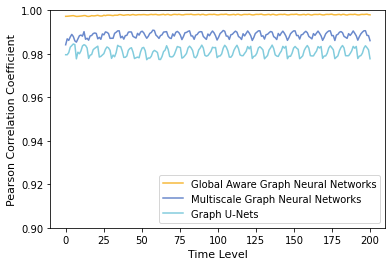

In [2]:
ED_out_0 = torch.load('/root/data1/circle_fenjie_EMD/encode_decode_output_01traj50200ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/duibishiyan/model_1_encode_decode_output1traj50200ts_vis.pt')
ED_out_2 = torch.load('/root/data1/duibishiyan/model_2_encode_decode_output1traj50200ts_vis.pt')

number_ts=200
ori=torch.load('/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj50200ts_vis.pt')
print(len(ori))   #200


for i in range(number_ts):
    
    uvw_0=ED_out_0[i].x.reshape(1,ED_out_0[i].x.shape[0],ED_out_0[i].x.shape[1])
    uvw_1=ED_out_1[i].x.reshape(1,ED_out_1[i].x.shape[0],ED_out_1[i].x.shape[1])
    uvw_2=ED_out_2[i].x.reshape(1,ED_out_2[i].x.shape[0],ED_out_2[i].x.shape[1])
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs_0 = uvw_0 if i==0 else np.vstack((outputs_0,uvw_0))
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_0 = np.hstack((outputs_0[:,:,0],outputs_0[:,:,1]))
output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_0.shape,output_1.shape,output_2.shape,input_.shape)

cc(input_, output_0, output_1, output_2)

2024-11-23 15:45:01.297331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 15:45:01.997950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22068 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9a:00.0, compute capability: 8.9


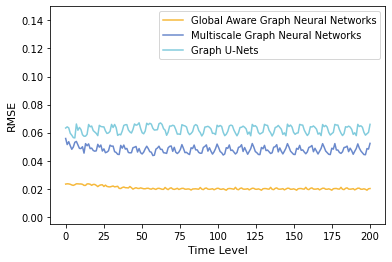

In [3]:
rmse_over_time(input_, output_0, output_1, output_2)

tensor([0.6040, 0.3584])
200


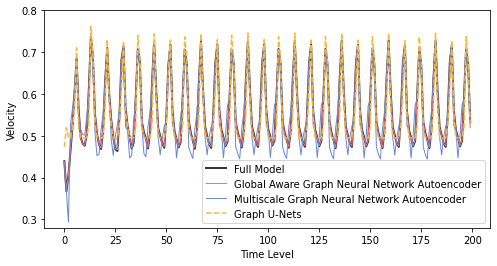

In [4]:
ED_out_0 = torch.load('/root/data1/circle_fenjie_EMD/encode_decode_output_01traj50200ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/duibishiyan/model_1_encode_decode_output1traj50200ts_vis.pt')
ED_out_2 = torch.load('/root/data1/duibishiyan/model_2_encode_decode_output1traj50200ts_vis.pt')

ts=200
ori=torch.load('/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj50200ts_vis.pt')
j=1704
fieldName='Velocity'
print(ori[0].mesh_pos[j]) 
point_over_time(ori,ED_out_0,ED_out_1, ED_out_2 ,j,ts , fieldName)

In [1]:
import torch
from processing_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ED_out_0 = torch.load('/root/data1/circle_fenjie_EMD/encode_decode_output_01traj50200ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/duibishiyan/model_1_encode_decode_output1traj50200ts_vis.pt')
ED_out_2 = torch.load('/root/data1/duibishiyan/model_2_encode_decode_output1traj50200ts_vis.pt')

ori=torch.load('/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj50200ts_vis.pt')
import shutil
 
def copy_vtu_file(source_path, destination_path):
    shutil.copy2(source_path, destination_path)
 
# 使用方法
t=110
satart_number_ts=50
source_vtu_path = '/root/data1/yuan_0/circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"


In [3]:
destination_vtu_path_0 = '/root/data1/duibishiyan/ours_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
destination_vtu_path_1 = '/root/data1/duibishiyan/Mul_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
destination_vtu_path_2 = '/root/data1/duibishiyan/Gcn_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
copy_vtu_file(source_vtu_path, destination_vtu_path_0)
copy_vtu_file(source_vtu_path, destination_vtu_path_1)
copy_vtu_file(source_vtu_path, destination_vtu_path_2)
mesh_0 =meshio.read(destination_vtu_path_0)
mesh_1 =meshio.read(destination_vtu_path_1)
mesh_2 =meshio.read(destination_vtu_path_2)
v_0 = abs(ori[t].x-ED_out_0[t].x)
v_0=v_0.numpy()
v_1 = abs(ori[t].x-ED_out_1[t].x)
v_1=v_1.numpy()
v_2 = abs(ori[t].x-ED_out_2[t].x)
v_2=v_2.numpy()
mesh_0.point_data["Velocity"][:,0:2]=v_0
mesh_1.point_data["Velocity"][:,0:2]=v_1
mesh_2.point_data["Velocity"][:,0:2]=v_2
meshio.write(destination_vtu_path_0, mesh_0)
meshio.write(destination_vtu_path_1, mesh_1)
meshio.write(destination_vtu_path_2, mesh_2)

test

In [2]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from circle_pooling import *

#from mgn import *
from tap_processing import *
#from global_tpok_mp import *

from circle_TAP_MP_Attention import *


In [3]:
number_trajectories=1
number_ts=150   #400
satart_number_ts=250
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.1
batch_size = 25
dataset_dir = '/root/data1/duibishiyan'
path='/root/data1/yuan_'
get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

/root/data1/yuan_0
402


2024-11-15 13:46:44.420316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 13:47:02.420218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20970 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9e:00.0, compute capability: 8.9


Done collecting data!
Done saving data!
Output Location:  /root/data1/duibishiyan/meshgraphnets_miniset1251traj250150ts_vis.pt


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
perm_list=torch.load('/root/data1/circle_fenjie_EMD/perm_list_150.pt')

print(device)
print(len(perm_list))
print(len(perm_list[0]))
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

cuda
1
3
cuda:0


In [5]:
file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = torch.load('/root/data1/circle_fenjie_EMD/EDstats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

sample = dataset[0]

in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 25    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=16
ae_dim=[300,128,64,32,16]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num = [3300,2500,1500]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False


6


In [6]:
model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)
pathED='/root/data1/circle_fenjie_EMD/ED_state_dict.pt'
model.load_state_dict(torch.load(pathED), strict=False)

print(len(dataset))   #6
n=int(len(dataset)/number_trajectories)
nn=int(n*batch_size)
print(n,nn)#6,150

#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)

file_path_ed= '/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj250150ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input))  #150
print(dataset_input[0])    

for i in range(number_trajectories):
  dataset_=dataset[i*n:(i+1)*n]
  num_=int(dataset_[0].x.shape[0]/(per_t*batch_size))
  loader_ = DataLoader(dataset_,  shuffle=False)
  pred_=torch.tensor([[0,0]]).type(torch.float).to(device)
  #pred_=torch.tensor([[0]]).type(torch.float).to(device)
  #per_t=1
  #batch_size=25    #改
  #device = 'cuda' if torch.cuda.is_available() else 'cpu'
  with torch.no_grad():
    for step, data in enumerate(loader_):
      data=data.to(device)
      
      out, _ = model(data, per_t ,perm_list[0], batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
      pred_=torch.vstack((pred_,out))
  pred_=pred_[1:,:]
  print(pred_.shape)   #150*3718,2
  pred_=pred_*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
  dataset_input_=dataset_input[i*nn:(i+1)*nn]

  pred_=pred_.to('cpu')

  viz_data_loader_ = copy.deepcopy(dataset_input_)



  for j in range(int(pred_.shape[0]/num_)):
    viz_data_loader_[j].x=pred_[j*num_:(j+1)*num_,:]
  
  torch.save(viz_data_loader_,dataset_dir+'/test_GA_encode_decode_output_'+str(i)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#200个data


6
6 150
150
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])
torch.Size([557700, 2])


In [1]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from models_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
number_trajectories=1
number_ts=150   #400
satart_number_ts=250
per_t=1
batch_size=25 
dataset = torch.load('/root/data1/duibishiyan/meshgraphnets_miniset1251traj250150ts_vis.pt')
print(len(dataset))
sample=dataset[0]
num=int(sample.x.shape[0]/(per_t*batch_size))
in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 26  #22
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 3
n_mlp_mp = 3

n_mp_down_topk = [1,1,1,1]
n_mp_up_topk = [1,1,1,2]
pool_ratios = [3500,2800,1500]#[1./2.]

#n_mp_down_topk = [1,1]
#n_mp_up_topk = [1,2]
#pool_ratios = [1/2]#[1./2.]
n_mp_down_enc = [3]#3
n_mp_up_enc = []
lengthscales_enc = []
n_mp_down_dec = [2,1,1]
n_mp_up_dec = [1,2]
lengthscales_dec = [0.5,1]
interp = 'learned'
act = F.elu
param_sharing = False
bounding_box = []
if len(lengthscales_dec) > 0:
        x_lo = sample.mesh_pos[:num,0].min() - lengthscales_dec[0]/2
        x_hi = sample.mesh_pos[:num,0].max() + lengthscales_dec[0]/2
        y_lo = sample.mesh_pos[:num,1].min() - lengthscales_dec[0]/2
        y_hi = sample.mesh_pos[:num,1].max() + lengthscales_dec[0]/2
        bounding_box = [x_lo.cpu().item(), x_hi.cpu().item(), y_lo.cpu().item(), y_hi.cpu().item()]

6


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load('/root/data1/circle_fenjie_EMD/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

model = model_1_GNN_TopK(
                in_channels_node,
                in_channels_edge,
                hidden_channels,
                out_channels,
                n_mlp_encode,
                n_mlp_mp,
                n_mp_down_topk,
                n_mp_up_topk,
                pool_ratios,
                n_mp_down_enc,
                n_mp_up_enc,
                n_mp_down_dec,
                n_mp_up_dec,
                lengthscales_enc,
                lengthscales_dec,
                bounding_box,
                interp,
                act,
                param_sharing,
                name='gnn_topk')
model.to(device)
pathED = '/root/data1/duibishiyan/model_1_ED_state_dict.pt'
model.load_state_dict(torch.load(pathED), strict=False)

loader = DataLoader(dataset,  shuffle=False)
print(len(dataset))
pred=torch.tensor([[0,0]]).type(torch.float).to(device)

    #改

with torch.no_grad():
  for step, data in enumerate(loader):
    data=data.to(device)
    out, _ = model(data, per_t , batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
    pred=torch.vstack((pred,out))
pred=pred[1:,:]
print(pred.shape)   #200*3718
pred=pred*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
#per_t=1
#batch_size=1
#get_dataset(number_trajectories,number_ts,per_t,batch_size,dataset_dir,path)

file_path_ed= '/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj250150ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input)) #200
print(dataset_input[0])
pred=pred.to('cpu')
viz_data = {}
viz_data_loader = copy.deepcopy(dataset_input)
for i in range(int(pred.shape[0]/num)):
  viz_data_loader[i].x=pred[i*num:(i+1)*num,:]
torch.save(viz_data_loader,'/root/data1/duibishiyan'+'/test_MAE_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#300个data

6
torch.Size([557700, 2])
150
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])


In [4]:
in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 22    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 6
n_mlp_mp = 4
encoding_dim=10
ae_dim=[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num = [3300,2500,1500] #[3300,2500,1500]

act = F.elu
param_sharing = False

In [6]:
model = model_2_GCN_Unet(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)
pathED = '/root/data1/duibishiyan/model_2_ED_state_dict.pt'
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load('/root/data1/duibishiyan/meshgraphnets_miniset1251traj250150ts_vis.pt')
loader = DataLoader(dataset,  shuffle=False)
print(len(dataset))
per_t=1
batch_size=25     #改
num=int(dataset[0].x.shape[0]/(per_t*batch_size))
print(num)
pred=torch.tensor([[0,0]]).type(torch.float).to(device)


with torch.no_grad():
  for step, data in enumerate(loader):
    data=data.to(device)
    out, _ = model(data, per_t , batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
    pred=torch.vstack((pred,out))
pred=pred[1:,:]
print(pred.shape)   #200*3718
pred=pred*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
#per_t=1
#batch_size=1
#get_dataset(number_trajectories,number_ts,per_t,batch_size,dataset_dir,path)

dataset_input = torch.load(file_path_ed)
print(len(dataset_input)) #200
print(dataset_input[0])
pred=pred.to('cpu')
viz_data = {}
viz_data_loader = copy.deepcopy(dataset_input)

for i in range(int(pred.shape[0]/num)):
  viz_data_loader[i].x=pred[i*num:(i+1)*num,:]
torch.save(viz_data_loader,'/root/data1/duibishiyan'+'/test_GU_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#300个data

6
3718
torch.Size([557700, 2])
150
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])


In [1]:
from processing_duibishiyan import *
import torch
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ED_out_0 = torch.load('/root/data1/duibishiyan/test_GA_encode_decode_output_01traj250150ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/duibishiyan/test_MAE_encode_decode_output1traj250150ts_vis.pt')
ED_out_2 = torch.load('/root/data1/duibishiyan/test_GU_encode_decode_output1traj250150ts_vis.pt')
number_ts=150
ori=torch.load('/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj250150ts_vis.pt')
print(len(ori))   #150

for i in range(number_ts):
    
    uvw_0=ED_out_0[i].x.reshape(1,ED_out_0[i].x.shape[0],ED_out_0[i].x.shape[1])
    uvw_1=ED_out_1[i].x.reshape(1,ED_out_1[i].x.shape[0],ED_out_1[i].x.shape[1])
    uvw_2=ED_out_2[i].x.reshape(1,ED_out_2[i].x.shape[0],ED_out_2[i].x.shape[1])
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs_0 = uvw_0 if i==0 else np.vstack((outputs_0,uvw_0))
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_0 = np.hstack((outputs_0[:,:,0],outputs_0[:,:,1]))
output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_0.shape,output_1.shape,output_2.shape,input_.shape)


150
(150, 7436) (150, 7436) (150, 7436) (150, 7436)


(150, 1) (150, 1)


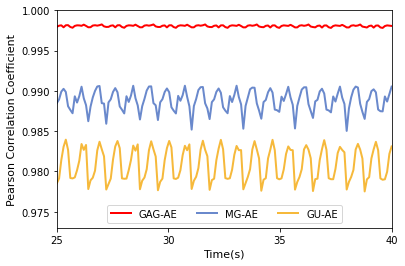

In [3]:
y_0,y_1,y_2=cc(input_, output_0, output_1, output_2)

In [4]:
print(np.mean(y_0),np.mean(y_1),np.mean(y_2))

0.9980487633966433 0.9888142424036029 0.9809391707977639


2025-04-23 18:15:00.059038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 18:15:00.871796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17514 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9b:00.0, compute capability: 8.9


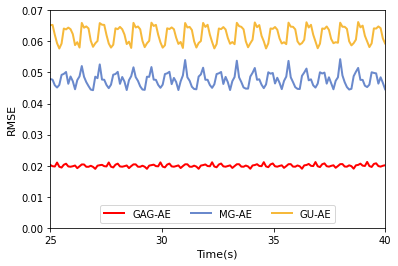

In [5]:
y_0,y_1,y_2=rmse_over_time(input_, output_0, output_1, output_2)

In [6]:
print(np.mean(y_0),np.mean(y_1),np.mean(y_2))

0.019981468 0.047683217 0.06210669


In [14]:
def acc(ori_data, rom_data):

    acc_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            ori=torch.Tensor(ori_data[i])
            rom=torch.Tensor(rom_data[i])
            value =torch.norm(ori- rom, p=2)/torch.norm(ori, p=2)
            
            if i == 0:
                acc_value = value
            else:
                acc_value = np.hstack((acc_value,value))
        acc_value = np.reshape(acc_value,(-1,1))
    return acc_value

In [15]:
acc0=acc(input_, output_0)
acc1=acc(input_, output_1)
acc2=acc(input_, output_2)
print(np.mean(acc0),np.mean(acc1),np.mean(acc2))


0.050021317 0.119363405 0.15547173


In [1]:
import torch
from processing_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([0.6040, 0.3584])
150


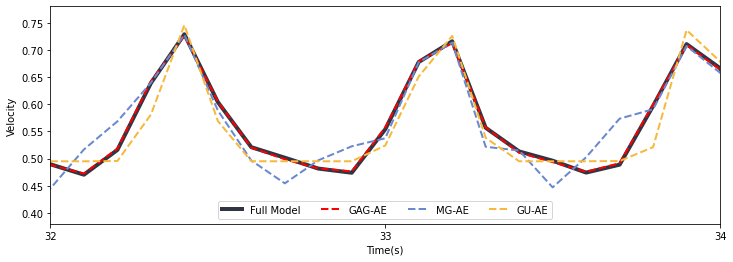

In [7]:
ED_out_0 = torch.load('/root/data1/duibishiyan/test_GA_encode_decode_output_01traj250150ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/duibishiyan/test_MAE_encode_decode_output1traj250150ts_vis.pt')
ED_out_2 = torch.load('/root/data1/duibishiyan/test_GU_encode_decode_output1traj250150ts_vis.pt')

ori=torch.load('/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj250150ts_vis.pt')

ts=150
j=1704
fieldName='Velocity'
print(ori[0].mesh_pos[j]) 
point_over_time(ori,ED_out_0,ED_out_1, ED_out_2 ,j,ts , fieldName)

In [3]:
ED_out_0 = torch.load('/root/data1/duibishiyan/test_GA_encode_decode_output_01traj250150ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/duibishiyan/test_MAE_encode_decode_output1traj250150ts_vis.pt')
ED_out_2 = torch.load('/root/data1/duibishiyan/test_GU_encode_decode_output1traj250150ts_vis.pt')

ori=torch.load('/root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj250150ts_vis.pt')

import shutil
 
def copy_vtu_file(source_path, destination_path):
    shutil.copy2(source_path, destination_path)
 
# 使用方法
t=130  #0-150
satart_number_ts=250
source_vtu_path = '/root/data1/yuan_0/circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"

In [4]:
destination_vtu_path_0 = '/root/data1/duibishiyan/test_yuan_GA_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
destination_vtu_path_1 = '/root/data1/duibishiyan/test_yuan_Mul_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
destination_vtu_path_2 = '/root/data1/duibishiyan/test_yuan_Gcn_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
copy_vtu_file(source_vtu_path, destination_vtu_path_0)
copy_vtu_file(source_vtu_path, destination_vtu_path_1)
copy_vtu_file(source_vtu_path, destination_vtu_path_2)
mesh_0 =meshio.read(destination_vtu_path_0)
mesh_1 =meshio.read(destination_vtu_path_1)
mesh_2 =meshio.read(destination_vtu_path_2)
v_0 = abs(ED_out_0[t].x)
v_0=v_0.numpy()
v_1 = abs(ED_out_1[t].x)
v_1=v_1.numpy()
v_2 = abs(ED_out_2[t].x)
v_2=v_2.numpy()
mesh_0.point_data["Velocity"][:,0:2]=v_0
mesh_1.point_data["Velocity"][:,0:2]=v_1
mesh_2.point_data["Velocity"][:,0:2]=v_2
meshio.write(destination_vtu_path_0, mesh_0)
meshio.write(destination_vtu_path_1, mesh_1)
meshio.write(destination_vtu_path_2, mesh_2)

In [8]:
destination_vtu_path_0 = '/root/data1/duibishiyan/test_GA_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
destination_vtu_path_1 = '/root/data1/duibishiyan/test_Mul_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
destination_vtu_path_2 = '/root/data1/duibishiyan/test_Gcn_circle-2d-drag_' + str(t+satart_number_ts)+ ".vtu"
copy_vtu_file(source_vtu_path, destination_vtu_path_0)
copy_vtu_file(source_vtu_path, destination_vtu_path_1)
copy_vtu_file(source_vtu_path, destination_vtu_path_2)
mesh_0 =meshio.read(destination_vtu_path_0)
mesh_1 =meshio.read(destination_vtu_path_1)
mesh_2 =meshio.read(destination_vtu_path_2)
v_0 = abs(ori[t].x-ED_out_0[t].x)
v_0=v_0.numpy()
v_1 = abs(ori[t].x-ED_out_1[t].x)
v_1=v_1.numpy()
v_2 = abs(ori[t].x-ED_out_2[t].x)
v_2=v_2.numpy()
mesh_0.point_data["Velocity"][:,0:2]=v_0
mesh_1.point_data["Velocity"][:,0:2]=v_1
mesh_2.point_data["Velocity"][:,0:2]=v_2
meshio.write(destination_vtu_path_0, mesh_0)
meshio.write(destination_vtu_path_1, mesh_1)
meshio.write(destination_vtu_path_2, mesh_2)